QF604 Econometrics of Financial Markets Group Project 
## Climate risk and Chinese stock volatility forecasting: Evidence from ESG index

Done by:
+ Denton Tng Jia Le
+ Joel Toh
+ Cheong Boon Yang
+ Hannah Xiang Sihan
+ Shannon Wong Keat Ye

#### Notes:
+ Full Dataset: 3 July 2017 - 30 June 2022 (1215 trading days)
+ In-Sample Period: 3 July 2017 - 18 July 2019 (500 trading days)
+ Out-of-Sample Test Period: 19 July 2019 - 30 June 2022 (715 trading days)

#### Major Problems Outstanding: 
+ We need to figure out the K number of lags (months) used for climate data 
+ We need to exercise caution when it comes to the ln(Tau) - hopefully it does not deviate from the R package's methodology
+ We need to source for the CEPU data which they used

### Import dependencies

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

#from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

from scipy.stats import boxcox
from scipy.special import inv_boxcox

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

### Defining Stationarity Tests

In [5]:
#H0: It is stationary
#H1: It is non-stationary

def kpss_test(data):
    result = kpss(data)
    labels = ['KPSS Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05: # We test at the 5% level of significance
        print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is non-stationary")
    else:
        print("Weak evidence against the null hypothesis, time series may be stationary")

#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(data):
    global result
    result = adfuller(data)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05: # We test at the 5% level of significance
        print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary")

### Reading in and Cleaning Datasets

Dependent Variables
+ CSI 300 ESG Index
+ SSEC Index

In [6]:
datasets = ['CSI 300 ESG Index.xlsx', 'SSEC Index.xlsx']

for i in range(len(datasets)):
    # Reads in data and saves raw data as (index_name)_raw_data
    globals()[datasets[i].split()[0]+'_raw_data'] = pd.read_excel(datasets[i])
    # Remove rows with NaN
    globals()[datasets[i].split()[0]+'_df'] = globals()[datasets[i].split()[0]+'_raw_data'].dropna(axis = 0)
    # Drop unnecessary columns
    globals()[datasets[i].split()[0]+'_df'] = globals()[datasets[i].split()[0]+'_df'][['date', 'close']]
    # Rename columns
    globals()[datasets[i].split()[0]+'_df'] = globals()[datasets[i].split()[0]+'_df'].rename(columns = {'date':'Date', 'close': str(datasets[i].split()[0])})
    # Set Date as index
    globals()[datasets[i].split()[0]+'_df'] = globals()[datasets[i].split()[0]+'_df'].set_index('Date')
    # Add column for Log Returns
    globals()[datasets[i].split()[0]+'_df'][str(datasets[i].split()[0])+' LnRet'] = np.log(globals()[datasets[i].split()[0]+'_df'][str(datasets[i].split()[0])] / globals()[datasets[i].split()[0]+'_df'][str(datasets[i].split()[0])].shift(1))
    # Add column for 100 * Log Returns
    globals()[datasets[i].split()[0]+'_df'][str(datasets[i].split()[0])+' 100 LnRet'] = globals()[datasets[i].split()[0]+'_df'][str(datasets[i].split()[0])+' LnRet'] * 100
    # Filter for desired date range (with extension data)
    globals()[datasets[i].split()[0]+'_df'] =  globals()[datasets[i].split()[0]+'_df'].loc[globals()[datasets[i].split()[0]+'_df'].index >= dt.datetime(2017,7,3)]
    # Create filtered df
    globals()[datasets[i].split()[0]+'_filtered_df'] = globals()[datasets[i].split()[0]+'_df'].loc[globals()[datasets[i].split()[0]+'_df'].index <= dt.datetime(2022,6,30)]
    # Train Test Split - Extract train_df
    globals()[datasets[i].split()[0]+'_train_df'] = globals()[datasets[i].split()[0]+'_df'].loc[globals()[datasets[i].split()[0]+'_df'].index <= dt.datetime(2019,7,18)] 
    # Train Test Split - Extract test_df
    globals()[datasets[i].split()[0]+'_test_df'] = globals()[datasets[i].split()[0]+'_df'].loc[globals()[datasets[i].split()[0]+'_df'].index > dt.datetime(2019,7,18)] 

Exogenous Variables
+ Chinese climate uncertainty (CU)
+ Chinese climate policy uncertainty (CEU)
+ Chinese economic policy uncertainty (CEPU)
+ U.S. climate policy uncertainty (UCPU)

In [7]:
sheet_names = ['CU','CEU','CEPU','UCPU']

for sheet in sheet_names:
    globals()[sheet+'_df'] = pd.read_excel('projData_v2.xlsx', sheet_name = sheet)

    if sheet in sheet_names[:2]:
        # Create Date column
        globals()[sheet+'_df']['yearmon'] = pd.to_datetime(globals()[sheet+'_df']['yearmon'], format = '%Y%m')
        # Rename Date and Data Series column
        globals()[sheet+'_df'] = globals()[sheet+'_df'].rename(columns = {'yearmon':'Date',globals()[sheet+'_df'].columns[1]:sheet})
        # Remove unncessary columns
        globals()[sheet+'_df'] = globals()[sheet+'_df'][['Date', str(sheet)]]

    if sheet == 'CEPU':
        # Create Date column
        globals()[sheet+'_df']['Date'] = globals()[sheet+'_df'].apply(lambda x: dt.datetime(int(x[0]), int(x[1]), 1) , axis = 1)
        # Rename column to CEPU
        globals()[sheet+'_df'] = globals()[sheet+'_df'].rename(columns = {str(globals()[sheet+'_df'].columns[2]):sheet})
        # Remove unnecessary columns
        globals()[sheet+'_df'] = globals()[sheet+'_df'][['Date','CEPU']]

    if sheet == 'UCPU':
        # Rename columns
        globals()[sheet+'_df'] = globals()[sheet+'_df'].rename(columns = {'date':'Date', str(globals()[sheet+'_df'].columns[1]):sheet})
    
    # For all sheets - Set Date as Index
    globals()[sheet+'_df'] = globals()[sheet+'_df'].set_index('Date')
    # For all sheets - Create Returns column
    globals()[sheet+'_df'][sheet+' LnRet'] = np.log(globals()[sheet+'_df'][sheet] / globals()[sheet+'_df'][sheet].shift(1))
    # For all sheets - Create filtered df
    globals()[sheet+'_filtered_df'] = globals()[sheet+'_df'].loc[(globals()[sheet+'_df'].index >= dt.datetime(2017,7,1)) & (globals()[sheet+'_df'].index <= dt.datetime(2022,6,1))]

### Descriptive Statistics
+ Note that, in the table of descriptive statistics within the paper, the writers have erroneously labeled $R_{ESG}$ as $R_{SSEC}$ and vice-versa
+ Additionally, there is some inconsistency in the writers' presentation of statistics. They have expressed the mean and SD for CSI 300 ESG Index in % (percentage points), without doing the same for SSEC

#### Dependent Variables

CSI 300 ESG Index

In [8]:
# Mean - CSI 300 ESG Index 100 Ln Ret (Expressed in %)
CSI_filtered_df['CSI 100 LnRet'].mean() * 100

1.7445371350752141

In [9]:
# SD - CSI 300 ESG Index 100 Ln Ret (Expressed in %)
CSI_filtered_df['CSI 100 LnRet'].std() * 100

129.27573446656834

In [10]:
# Skewness
CSI_filtered_df['CSI 100 LnRet'].skew()

-0.4484336591712423

In [11]:
# Kurtosis
CSI_filtered_df['CSI 100 LnRet'].kurt()

3.0100583465662565

In [12]:
# ADF Test
# Inaccurate
adfuller_test(CSI_filtered_df['CSI 100 LnRet'])

ADF Test Statistic : -17.869878738185484
p-value : 3.030506455046435e-30
#Lags Used : 3
Number of Observations Used : 1211
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


SSEC

In [13]:
# Mean - SECC 100 Ln Ret
SSEC_filtered_df['SSEC 100 LnRet'].mean()

0.005151200377155893

In [14]:
# SD - SECC 100 Ln Ret
SSEC_filtered_df['SSEC 100 LnRet'].std()

1.1273832658657625

In [15]:
# Skewness
SSEC_filtered_df['SSEC 100 LnRet'].skew()

-0.6907379148168465

In [16]:
# Kurtosis
SSEC_filtered_df['SSEC 100 LnRet'].kurt()

5.222667100739146

In [17]:
# ADF Test
# Inaccurate
adfuller_test(SSEC_filtered_df['SSEC 100 LnRet'])

ADF Test Statistic : -17.930978354204388
p-value : 2.8832985229534548e-30
#Lags Used : 3
Number of Observations Used : 1211
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


#### Exogenous Variables
CU

In [18]:
CU_filtered_df['CU LnRet'].mean()

0.04755027904690041

In [19]:
CU_filtered_df['CU LnRet'].std()

0.8805238652193124

In [20]:
CU_filtered_df['CU LnRet'].skew()

0.863415260559998

In [21]:
CU_filtered_df['CU LnRet'].kurt()

1.6476771906985292

In [22]:
# Inaccurate
adfuller_test(CU_filtered_df['CU LnRet'])

ADF Test Statistic : -8.460787231979003
p-value : 1.5694144304553543e-13
#Lags Used : 1
Number of Observations Used : 58
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


CEU

In [23]:
CEU_filtered_df['CEU LnRet'].mean()

0.026969171048225177

In [24]:
CEU_filtered_df['CEU LnRet'].std()

0.7807588307903405

In [25]:
CEU_filtered_df['CEU LnRet'].skew()

-0.14288273160491982

In [26]:
CEU_filtered_df['CEU LnRet'].kurt()

-0.18291055257109035

In [27]:
# Inaccurate
adfuller_test(CEU_filtered_df['CEU LnRet'])

ADF Test Statistic : -9.07870031068125
p-value : 4.111843900221395e-15
#Lags Used : 1
Number of Observations Used : 58
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


UCPU

In [28]:
UCPU_filtered_df['UCPU LnRet'].mean()

-0.0010568388345684632

In [29]:
UCPU_filtered_df['UCPU LnRet'].std()

0.36083331378229294

In [30]:
UCPU_filtered_df['UCPU LnRet'].skew()

0.32259460322064554

In [31]:
UCPU_filtered_df['UCPU LnRet'].kurt()

1.4047255211591598

In [32]:
# Inaccurate
adfuller_test(UCPU_filtered_df['UCPU LnRet'])

ADF Test Statistic : -6.031260335568804
p-value : 1.416165683738448e-07
#Lags Used : 5
Number of Observations Used : 54
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


## Post Model Fitting in R: Forecasting and Analysis of Results

+ Model fitting will be performed in R using the mfGARCH package, yielding fitted parameters which can then be used to generate forecasts of $\tau$ in Python by substituting fitted parameters into known formulae

$ ln(\tau_7)$  

$ =  m $  
$ + \; \theta_{RV} \times \psi_6(w_1, w_2) \times RV_6  \;\;\;+\;\;\; \theta_{INDEX} \times \psi_6(w_1, w_2) \times INDEX_6 $  
$ + \; \theta_{RV} \times \psi_5(w_1, w_2) \times RV_5  \;\;\;+\;\;\; \theta_{INDEX} \times \psi_5(w_1, w_2) \times INDEX_5 $  
$ + \; \theta_{RV} \times \psi_4(w_1, w_2) \times RV_4  \;\;\;+\;\;\; \theta_{INDEX} \times \psi_4(w_1, w_2) \times INDEX_4 $  
$ + \; \theta_{RV} \times \psi_3(w_1, w_2) \times RV_3  \;\;\;+\;\;\; \theta_{INDEX} \times \psi_3(w_1, w_2) \times INDEX_3 $  
$ + \; \theta_{RV} \times \psi_2(w_1, w_2) \times RV_2  \;\;\;+\;\;\; \theta_{INDEX} \times \psi_2(w_1, w_2) \times INDEX_2 $  
$ + \; \theta_{RV} \times \psi_1(w_1, w_2) \times RV_1  \;\;\;+\;\;\; \theta_{INDEX} \times \psi_1(w_1, w_2) \times INDEX_1 $  

In [33]:
def forecast(model_name, modelparams_df, exog_df, all_df, K): 

    global rv_psi, index_psi, all_results_df, lntau_df
    '''
    model_name = 
        model_csi_rv_cu, 
        model_csi_rv_ceu, 
        model_csi_rv_cepu, 
        model_csi_rv_ucpu, 
        model_ssec_rv_cu, 
        model_ssec_rv_ceu, 
        model_ssec_rv_cepu, 
        model_ssec_rv_ucpu, 
        model_csi_rv, 
        model_ssec_rv

    df = daily for GARCH

    exog_df = monthly for MIDAS

    '''
    
    model_name = str(model_name)
    model_components = model_name.split('_')
    
    y = model_components[1]

    midas1 = model_components[1]+'_'+model_components[2].upper()

    if len(model_components) < 4: 
        midas2 = None
    else: 
        midas2 = model_components[3].upper()

    K = K # arbitrary K

    ### Getting model params
    mu = modelparams_df.loc[modelparams_df['model'] == model_name]['mu'].iloc[0]
    alpha = modelparams_df.loc[modelparams_df['model'] == model_name]['alpha'].iloc[0]
    beta = modelparams_df.loc[modelparams_df['model'] == model_name]['beta'].iloc[0]
    gamma = modelparams_df.loc[modelparams_df['model'] == model_name]['gamma'].iloc[0]
    m = modelparams_df.loc[modelparams_df['model'] == model_name]['m'].iloc[0]
    theta = modelparams_df.loc[modelparams_df['model'] == model_name]['theta'].iloc[0]
    w2 = modelparams_df.loc[modelparams_df['model'] == model_name]['w2'].iloc[0]
    theta_two = modelparams_df.loc[modelparams_df['model'] == model_name]['theta.two'].iloc[0]
    w2_two = modelparams_df.loc[modelparams_df['model'] == model_name]['w2.two'].iloc[0]

    #print(mu, alpha, beta, gamma, m, theta, w2, theta_two, w2_two)

    ### GARCH(1,1) Forecast

    
    ### MIDAS Forecast

    # Weights (psi) ########################################################################################################
    w1 = 1 # beta weighing function w1 = 1

    
    # rv_psi
    rv_psi = [0] # start with a number at position 0 so that index will be representative of k later (no need -1)
    
    for k in range(1, K+1):
        
        numerator = ((k/(K+1))**(w1-1)) * ((1 - (k/(K+1)))**(w2-1))
        denominator = 0
        for j in range(1, K+1):
            denominator += ((j/(K+1))**(w1-1)) * ((1 - (j/(K+1)))**(w2-1))
        
        rv_psi.append(numerator/denominator)
        # sum(psi) == 1, sanity checked

    if midas2 != None:

        # index_psi
        index_psi = [0] # start with a number at position 0 so that index will be representative of k later (no need -1)

        for k in range(1, K+1):
            
            numerator = ((k/(K+1))**(w1-1)) * ((1 - (k/(K+1)))**(w2_two-1))
            denominator = 0
            for j in range(1, K+1):
                denominator += ((j/(K+1))**(w1-1)) * ((1 - (j/(K+1)))**(w2_two-1))
            
            index_psi.append(numerator/denominator)
    
    ##########################################################################################################################

    if midas2 == None: 
        tempdf = exog_df[['year_month',midas1]]
        for k in range(1,K+1):
            shift_by = K-k+1 # How many rows to shift, since when t=1 is the earliest value, need to shift the most
            col_name = f'{midas1}{k}'
            tempdf[col_name] = tempdf[midas1].shift(shift_by)
            ### temp df prepared with the appropriate lags
    
    if midas2 != None: # 2 MIDAS variable
        tempdf = exog_df[['year_month',midas1, midas2]]
        for k in range(1,K+1):
            shift_by = K-k+1 # How many rows to shift, since when t=1 is the earliest value, need to shift the most
            col_name1 = f'{midas1}{k}'
            col_name2 = f'{midas2}{k}'
            tempdf[col_name1] = tempdf[midas1].shift(shift_by)
            tempdf[col_name2] = tempdf[midas1].shift(shift_by)
            ### temp df prepared with the appropriate lags
    
    tempdf = tempdf.dropna() # drop off K rows
    #print(tempdf)
    ### Time to calculate some TAUs!
    
    if midas2 == None:
        for k in range(1, K+1):
            tempdf[f'{midas1}psi{k}'] = rv_psi[k]

        tempsum = m
        for k in range(1, K+1):
            toadd = tempdf[f'{midas1}{k}'] * tempdf[f'{midas1}psi{k}']
            tempsum += theta * toadd
        tempdf['lntau'] = tempsum

        # tempdf['lntau'] = m + (theta * (tempdf[f'{midas1}{1}'] * tempdf[f'{midas1}psi{1}'] +\
        #                             tempdf[f'{midas1}{2}'] * tempdf[f'{midas1}psi{2}'] +\
        #                             tempdf[f'{midas1}{3}'] * tempdf[f'{midas1}psi{3}'] +\
        #                             tempdf[f'{midas1}{4}'] * tempdf[f'{midas1}psi{4}'] +\
        #                             tempdf[f'{midas1}{5}'] * tempdf[f'{midas1}psi{5}'] +\
        #                             tempdf[f'{midas1}{6}'] * tempdf[f'{midas1}psi{6}']))

    if midas2 != None:
        for k in range(1, K+1):
            tempdf[f'{midas1}psi{k}'] = rv_psi[k]
            tempdf[f'{midas2}psi{k}'] = index_psi[k]
        
        tempsum = m
        for k in range(1, K+1):
            toadd1 = tempdf[f'{midas1}{k}'] * tempdf[f'{midas1}psi{k}']
            toadd2 = tempdf[f'{midas2}{k}'] * tempdf[f'{midas2}psi{k}']
            tempsum += theta * toadd1
            tempsum += theta_two * toadd2
        tempdf['lntau'] = tempsum
        # tempdf['lntau'] = m + (theta * (tempdf[f'{midas1}{1}'] * tempdf[f'{midas1}psi{1}'] +\
        #                             tempdf[f'{midas1}{2}'] * tempdf[f'{midas1}psi{2}'] +\
        #                             tempdf[f'{midas1}{3}'] * tempdf[f'{midas1}psi{3}'] +\
        #                             tempdf[f'{midas1}{4}'] * tempdf[f'{midas1}psi{4}'] +\
        #                             tempdf[f'{midas1}{5}'] * tempdf[f'{midas1}psi{5}'] +\
        #                             tempdf[f'{midas1}{6}'] * tempdf[f'{midas1}psi{6}'] ) +\
        #                     theta_two * (tempdf[f'{midas2}{1}'] * tempdf[f'{midas2}psi{1}'] +\
        #                                     tempdf[f'{midas2}{2}'] * tempdf[f'{midas2}psi{2}'] +\
        #                                     tempdf[f'{midas2}{3}'] * tempdf[f'{midas2}psi{3}'] +\
        #                                     tempdf[f'{midas2}{4}'] * tempdf[f'{midas2}psi{4}'] +\
        #                                     tempdf[f'{midas2}{5}'] * tempdf[f'{midas2}psi{5}'] +\
        #                                     tempdf[f'{midas2}{6}'] * tempdf[f'{midas2}psi{6}'] ))

    lntau_df = tempdf[['year_month', 'lntau']]
    #print(tempdf[['year_month', 'lntau']])
    ### Adding the taus to the daily table
    all_results_df = all_df.merge(tempdf[['year_month', 'lntau']], on='year_month', how='left', suffixes=('', '_monthly'))

    return all_results_df[['date', 'year_month', 'lntau']]

### Calculating the Short-Term Component of Conditional Volatility g

The short-term component of conditional volatility is assumed to follow a GARCH(1,1) process:

\begin{align*}

g_{i,t} = (1 - \alpha - \beta) + \alpha \frac{(r_{i,t} - \mu)^2}{\tau_i} + \beta g_{i-1,t}

\end{align*}

In [34]:
# Read in initial values of g0 (calculated by R)
initial_g_df = pd.read_csv('initial_g.csv')
initial_g_df = initial_g_df.rename(columns = {initial_g_df.columns[0]:'Model',initial_g_df.columns[1]:'g0'})
initial_g_df

,Model,g0
0,model_csi_rv_cu,0.804488
1,model_csi_rv_ceu,0.785878
2,model_csi_rv_cepu,0.858725
3,model_csi_rv_ucpu,0.889145
4,model_ssec_rv_cu,0.836879
5,model_ssec_rv_ceu,0.801532
6,model_ssec_rv_cepu,0.907244
7,model_ssec_rv_ucpu,0.985833
8,model_csi_rv,0.802720
9,model_ssec_rv,0.837763


In [35]:
# Attempt 1 assumes we back into rit and tau from lnret100 and lntau respectively
def calculate_g(modelparamsdf, exogdf10, all_df, initial_g_df, k):

    # Let n = length of forecast period (in days)

    # Set first date of forecast: [This is the TRADING DAY after g0 date]
    forecast_start_date = dt.datetime(2019, 7, 19)

    # Set last date of forecast
    forecast_end_date = dt.datetime(2022, 6, 30)

    global git_dict
    git_dict = {}
    
    for model in modelparamsdf['model']:
        globals()[model+'forecasttestdf'] = forecast(model, modelparamsdf, exogdf10, all_df, k)

        # global globals()[model+'forecasttestdf'] 
        # Extract g0 from initial_g_df
        g0 = initial_g_df.loc[initial_g_df['Model'] == model]['g0'].values[0]

        # Extract fitted GARCH MIDAS parameters
        mu = modelparamsdf.loc[modelparamsdf['model'] == model]['mu'].values[0] 
        alpha = modelparamsdf.loc[modelparamsdf['model'] == model]['alpha'].values[0] 
        beta = modelparamsdf.loc[modelparamsdf['model'] == model]['beta'].values[0] 

        # Extract from forecasttestdf (all_results_df)
        all_results_df

        # Extract lnret100
        temp_underlying_data = str(model).split('_')[1] # Checks csi or ssec
        if temp_underlying_data == 'csi':
            lnret100 = all_results_df.loc[(all_results_df['date'] >= forecast_start_date) & (all_results_df['date'] <= forecast_end_date)]['csi_lnret100']

        else:
            lnret100 = all_results_df.loc[(all_results_df['date'] >= forecast_start_date) & (all_results_df['date'] <= forecast_end_date)]['ssec_lnret100']

        # Calculate rit
        lnret100 = np.array(lnret100) # Convert to array to perform vector operations
#######################################        
        rit = (lnret100 / 100) # To back into ri,t, first divide by 100, then take exponent
#######################################
                
        # Extract lnTau
        lntau = all_results_df.loc[(all_results_df['date'] >= forecast_start_date) & (all_results_df['date'] <= forecast_end_date)]['lntau']
        lntau = np.array(lntau) # Convert to array to perform vector operations
        
#######################################
        tau = np.exp(lntau) # To back into ri,t, first divide by 100, then take exponent
#######################################
        # Initialise list
        git_list = []

        # Set up for loop to loop through each day of forecast period, calculating and appending git
        for i in range(len(rit)):
            if i == 0: # uses g0 for first iteration
                git = (1 - alpha - beta) + alpha * ( ((rit[i] - mu)**2) / tau[i] ) + beta * g0
                git_list.append(git)
            else:
                git = (1 - alpha - beta) + alpha * ( ((rit[i] - mu)**2) / tau[i] ) + beta * git_list[-1]
                git_list.append(git)


        git_dict[model] = git_list

        # globals()[model+'_git_df'] = pd.DataFrame(dict(date = all_results_df.loc[(all_results_df['date'] >= forecast_start_date) & (all_results_df['date'] <= forecast_end_date)]['date'], g = np.array(git_list)))

    return git_dict

## Out-of-Sample Performance Measures

### Defining Out of Sample Performance Measures

$R_{OOS}^2$

\begin{align*}

R_{OOS}^2 = 1 - \frac{\sum_{t = 1}^\delta (\sigma_t - \hat{\sigma_t})^2 }{\sum_{t = 1}^\delta (\sigma_t - \hat{\sigma}_{t,bench})^2 }

\end{align*}

In [36]:
# Note: 
# sigma_actual refers to calculated values given by ri,t - mu where mu is a fitted GARCH-MIDAS parameter
# sigma_hat refers to forecasts generated by the competing model (ie. GARCH-MIDAS-CU)
# sigma_bench refers to forecasts generated by the vanilla GARCH-MIDAS model (ie. only RV)
# Ensure that columns/series of the same length are passed into the function

def r_squared_OOS(sigma_actual, sigma_hat, sigma_bench):

    # check lengths of data series are equal
    if len(sigma_actual) == len(sigma_hat) == len(sigma_bench):
        RSS = ((sigma_actual - sigma_hat) ** 2).sum()
        TSS = ((sigma_actual - sigma_bench) ** 2).sum()
        return 1 - RSS/TSS
    else:
        print('Error. Samples are not of the same length.')
    

### Loop testing for the best Lag (K) for best R_oos results

In [37]:
sigmahat_lags_dict = {}
R_oos_lags_dict = {}

for k in range(2,15+1):
    # reading in data (with the appropriate lag)
    modelparamsdf = pd.read_excel('allData090324Lag.xlsx', sheet_name=f'model_params_k{k}')
    exogdf = pd.read_excel('allData090324Lag.xlsx', sheet_name='exog')
    alldf = pd.read_excel('allData090324Lag.xlsx', sheet_name ='all')

    # creating lntau_dict
    lntau_dict = {}
    for model in modelparamsdf['model']:
        results_df = forecast(model, modelparamsdf, exogdf, alldf, k)
        lntau_dict[model] = results_df

    # calculate short term component (g)
    initial_g_df = pd.read_csv('initial_g.csv')
    initial_g_df = initial_g_df.rename(columns = {initial_g_df.columns[0]:'Model',initial_g_df.columns[1]:'g0'})

    # generate git
    calculate_g(modelparamsdf, exogdf, alldf, initial_g_df, k)

    sigmahat_dict = {}

    for model in modelparamsdf['model']:
        tau = np.exp(lntau_dict[model]['lntau'].iloc[1215-715:1215])
        git = git_dict[model]
        sigmahat_dict[model] = np.sqrt(tau * git)

    # save sigmahats (of different lags)
    sigmahat_lags_dict[f'lag{k}'] = sigmahat_dict

    # Get sigmat
    sigmat = pd.read_excel("allData090324Lag.xlsx")
    sigmat = sigmat[['date','ssec_lnret100', 'csi_lnret100']]
    sigmat = sigmat.iloc[1215-715:1215]

    R_oos = {}

    for model in modelparamsdf['model']:
        if model.split('_')[1] == 'csi':
            actual = sigmat['csi_lnret100']
        else: 
            actual = sigmat['ssec_lnret100']
        #actual = sigmat[f'{model}_sigmat']
        hat = sigmahat_dict[model]
        bench_name_list = model.split('_')
        bench_name = bench_name_list[0]+'_'+bench_name_list[1]+'_'+bench_name_list[2]
        bench = sigmahat_dict[bench_name]

        R_oos[model] = r_squared_OOS(actual, hat, bench)
    
    R_oos_lags_dict[f'lag{k}'] = R_oos

    print(f'Lag{k} Done')

Lag2 Done


Lag3 Done
Lag4 Done
Lag5 Done
Lag6 Done
Lag7 Done
Lag8 Done
Lag9 Done
Lag10 Done
Lag11 Done
Lag12 Done
Lag13 Done
Lag14 Done
Lag15 Done


In [38]:
pd.DataFrame(R_oos_lags_dict)

,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,lag13,lag14,lag15
model_csi_rv_cu,-0.019755,0.028878,-0.022963,-0.014689,0.098976,0.019883,0.018032,0.026479,0.041285,0.087289,0.398759,-0.004283,0.094993,-177.466324
model_csi_rv_ceu,0.197330,-0.122030,-0.037942,-0.035441,-0.034497,-0.011460,-0.030626,0.007948,-0.104168,-0.044884,-0.295180,-0.399677,-57.997488,-41.450636
model_csi_rv_cepu,0.017295,0.097144,0.151876,0.176675,0.207357,0.178363,0.204008,0.230667,0.257914,0.968468,0.978204,0.451175,0.010042,-12.970053
model_csi_rv_ucpu,0.136176,0.102465,0.168082,0.128757,0.157316,0.375214,0.096973,0.120078,0.135322,0.178793,0.158616,0.194857,0.490157,0.294385
model_ssec_rv_cu,-56.227262,0.081675,-0.033601,-0.044803,0.088249,-0.851171,0.966116,-0.266503,-0.594303,0.038393,-0.165675,-0.032606,0.288697,-3.477020
model_ssec_rv_ceu,-0.399682,-0.090611,-0.066873,-0.062066,-0.034067,-0.590204,-0.413038,-0.102394,-0.032416,0.014554,-0.216463,-0.005815,-44.993282,-0.131617
model_ssec_rv_cepu,-44.996402,0.227916,0.142984,0.210104,0.189717,-0.251408,-0.134563,0.132048,0.225349,0.969270,0.300866,0.976688,0.085436,0.985629
model_ssec_rv_ucpu,-6.124993,0.143791,0.200194,0.372039,0.449683,0.644550,0.329631,0.484207,0.901926,0.931378,0.987418,0.968356,0.716601,0.985748
model_csi_rv,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
model_ssec_rv,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Lag 9 is chosen for its better performing R_oos

In [39]:
### Preparing Lag9 as model to be used

lag9model = pd.DataFrame(sigmahat_lags_dict['lag9'])

### Getting sigmat-s
lag9model_sigmat = pd.read_excel("allData090324Lag.xlsx")
lag9model_sigmat = lag9model_sigmat[['date','ssec_lnret100', 'csi_lnret100']]
lag9model_sigmat = lag9model_sigmat.iloc[1215-715:1215]

In [40]:
lag9model

,model_csi_rv_cu,model_csi_rv_ceu,model_csi_rv_cepu,model_csi_rv_ucpu,model_ssec_rv_cu,model_ssec_rv_ceu,model_ssec_rv_cepu,model_ssec_rv_ucpu,model_csi_rv,model_ssec_rv
500,1.410412,1.401913,0.479808,0.833592,1.180996,0.636892,0.436700,0.570234,1.483916,1.010750
501,1.433726,1.427737,0.485661,0.840708,1.198596,0.648048,0.439470,0.560518,1.509071,1.009202
502,1.452729,1.448677,0.490351,0.846576,1.212490,0.657028,0.441815,0.551053,1.529484,1.007903
503,1.468263,1.465711,0.494117,0.851422,1.223490,0.664279,0.443802,0.541819,1.546097,1.006805
504,1.480990,1.479604,0.497147,0.855428,1.232219,0.670148,0.445487,0.532800,1.559650,1.005869
...,...,...,...,...,...,...,...,...,...,...
1210,1.384712,1.418111,1.429713,1.467384,1.676810,1.712983,1.379581,0.538044,1.406362,1.362760
1211,1.384712,1.418111,1.429713,1.467384,1.676810,1.712983,1.379581,0.538051,1.406362,1.362764
1212,1.384712,1.418111,1.429713,1.467384,1.676810,1.712983,1.379581,0.538058,1.406362,1.362767
1213,1.384712,1.418111,1.429713,1.467384,1.676810,1.712983,1.379581,0.538032,1.406362,1.362755


In [41]:
lag9model_sigmat

,date,ssec_lnret100,csi_lnret100
500,2019-07-19,0.790339,1.168284
501,2019-07-22,-1.281343,-0.475577
502,2019-07-23,0.448254,0.099876
503,2019-07-24,0.801623,0.881714
504,2019-07-25,0.480495,0.895603
...,...,...,...
1210,2022-06-24,0.887575,1.174468
1211,2022-06-27,0.875032,1.159203
1212,2022-06-28,0.884456,0.987749
1213,2022-06-29,-1.408734,-1.534911


## Other Performance Indicators

### Mean Squared Predicted Error - Adjusted (MSPE-Adj) (Clark and West 2007)

\begin{align*}

\hat{\sigma_1}^2 = \frac{1}{P} \sum (y_{t+\tau} - \hat{y}_{1t,t+\tau})^2

, \hat{\sigma_2}^2 = \frac{1}{P} \sum (y_{t+\tau} - \hat{y}_{2t,t+\tau})^2

\\

\hat{\sigma_2}^2 - adj. = \frac{1}{P} \sum (y_{t+\tau} - \hat{y}_{2t,t+\tau})^2 - \frac{1}{P} \sum (\hat{y}_{1t,t+\tau} - \hat{y}_{2t,t+\tau})^2

\end{align*}

where P refers to the number of predictions used in computing these sample averages
+ 1 likely refers to vanilla GARCH-MIDAS (Single MIDAS variable - RV)
+ 2 likely refers to competing model

In [42]:
def MSPE_Adj(sigma_actual, sigma_hat, sigma_bench):
    if len(sigma_actual) == len(sigma_hat) == len(sigma_bench):
        P = len(sigma_actual)
        MSPE_1 = (1/P)*((sigma_actual-sigma_bench)**2).sum()
        MSPE_2 = (1/P)*((sigma_actual-sigma_hat)**2).sum()
        adj = (1/P)*((sigma_bench-sigma_hat)**2).sum()
        return (MSPE_1-(MSPE_2-adj))
    else:
        print('Error. Samples are not of the same length.')

In [43]:
MSPE_Adj_lag9_dict = {}

for model in modelparamsdf['model']:
    if model.split('_')[1] == 'csi':
        actual = lag9model_sigmat['csi_lnret100']
        bench = lag9model['model_csi_rv']
    else:
        actual = lag9model_sigmat['ssec_lnret100']
        bench = lag9model['model_ssec_rv']

    hat = lag9model[model]

    MSPE_Adj_lag9_dict[model] = MSPE_Adj(actual, hat, bench)

MSPE_Adj_lag9_dict

{'model_csi_rv_cu': 0.09823658477353758,
 'model_csi_rv_ceu': 0.02984358139909027,
 'model_csi_rv_cepu': 1.08908071284857,
 'model_csi_rv_ucpu': 0.5209406469565412,
 'model_ssec_rv_cu': -0.6588316230139992,
 'model_ssec_rv_ceu': -0.2228972041634263,
 'model_ssec_rv_cepu': 0.4350106232938842,
 'model_ssec_rv_ucpu': 1.9829788562070378,
 'model_csi_rv': 0.0,
 'model_ssec_rv': 0.0}

In [44]:
lag9model

,model_csi_rv_cu,model_csi_rv_ceu,model_csi_rv_cepu,model_csi_rv_ucpu,model_ssec_rv_cu,model_ssec_rv_ceu,model_ssec_rv_cepu,model_ssec_rv_ucpu,model_csi_rv,model_ssec_rv
500,1.410412,1.401913,0.479808,0.833592,1.180996,0.636892,0.436700,0.570234,1.483916,1.010750
501,1.433726,1.427737,0.485661,0.840708,1.198596,0.648048,0.439470,0.560518,1.509071,1.009202
502,1.452729,1.448677,0.490351,0.846576,1.212490,0.657028,0.441815,0.551053,1.529484,1.007903
503,1.468263,1.465711,0.494117,0.851422,1.223490,0.664279,0.443802,0.541819,1.546097,1.006805
504,1.480990,1.479604,0.497147,0.855428,1.232219,0.670148,0.445487,0.532800,1.559650,1.005869
...,...,...,...,...,...,...,...,...,...,...
1210,1.384712,1.418111,1.429713,1.467384,1.676810,1.712983,1.379581,0.538044,1.406362,1.362760
1211,1.384712,1.418111,1.429713,1.467384,1.676810,1.712983,1.379581,0.538051,1.406362,1.362764
1212,1.384712,1.418111,1.429713,1.467384,1.676810,1.712983,1.379581,0.538058,1.406362,1.362767
1213,1.384712,1.418111,1.429713,1.467384,1.676810,1.712983,1.379581,0.538032,1.406362,1.362755


In [45]:
lag9modeldates = lag9model_sigmat['date']

### Cumulative Squared Forecast Error (CumSFE)

\begin{align*}

CumSFE = \sum_{t=1}^{\delta} ((\hat{\sigma}_{i,t}^{i,model} - \sigma_t)^2 - (\hat{\sigma}_{i,t}^{i,bench} - \sigma_t)^2 )

\end{align*}

In [46]:
def cumSFE(sigma_actual, sigma_hat, sigma_bench, date):

    # check lengths of data series are equal
    if not(len(sigma_actual) == len(sigma_hat) == len(sigma_bench) == len(date)):
        print('Error. Samples are not of the same length.')
        
    else:
        df = pd.DataFrame({'date':date, 'sigma_actual': sigma_actual, 'sigma_hat': sigma_hat, 'sigma_bench': sigma_bench})
        df['SFE'] = ((df['sigma_hat'] - df['sigma_actual']) ** 2 - (df['sigma_bench'] - df['sigma_actual']) ** 2)
        df['CSFE'] = df['SFE'].cumsum()
        return df[['date', 'CSFE']]
        

In [47]:
cumSFE_lag9_dict = {}

for model in modelparamsdf['model']:
    if model.split('_')[1] == 'csi':
        actual = lag9model_sigmat['csi_lnret100']
        bench = lag9model['model_csi_rv']
    else:
        actual = lag9model_sigmat['ssec_lnret100']
        bench = lag9model['model_ssec_rv']

    hat = lag9model[model]

    cumSFE_lag9_dict[model] = cumSFE(actual, hat, bench, lag9modeldates)

cumSFE_lag9_dict

{'model_csi_rv_cu':            date       CSFE
 500  2019-07-19  -0.040997
 501  2019-07-22  -0.334388
 502  2019-07-23  -0.547955
 503  2019-07-24  -0.645320
 504  2019-07-25  -0.743602
 ...         ...        ...
 1210 2022-06-24 -68.870084
 1211 2022-06-27 -68.880318
 1212 2022-06-28 -68.897975
 1213 2022-06-29 -69.024863
 1214 2022-06-30 -69.026143
 
 [715 rows x 2 columns],
 'model_csi_rv_ceu':            date       CSFE
 500  2019-07-19  -0.045041
 501  2019-07-22  -0.361263
 502  2019-07-23  -0.585777
 503  2019-07-24  -0.686129
 504  2019-07-25  -0.786030
 ...         ...        ...
 1210 2022-06-24 -20.805549
 1211 2022-06-27 -20.799603
 1212 2022-06-28 -20.789628
 1213 2022-06-29 -20.720372
 1214 2022-06-30 -20.719285
 
 [715 rows x 2 columns],
 'model_csi_rv_cepu':            date        CSFE
 500  2019-07-19    0.374375
 501  2019-07-22   -2.640475
 502  2019-07-23   -4.531783
 503  2019-07-24   -4.822957
 504  2019-07-25   -5.105150
 ...         ...         ...
 1210 2022-

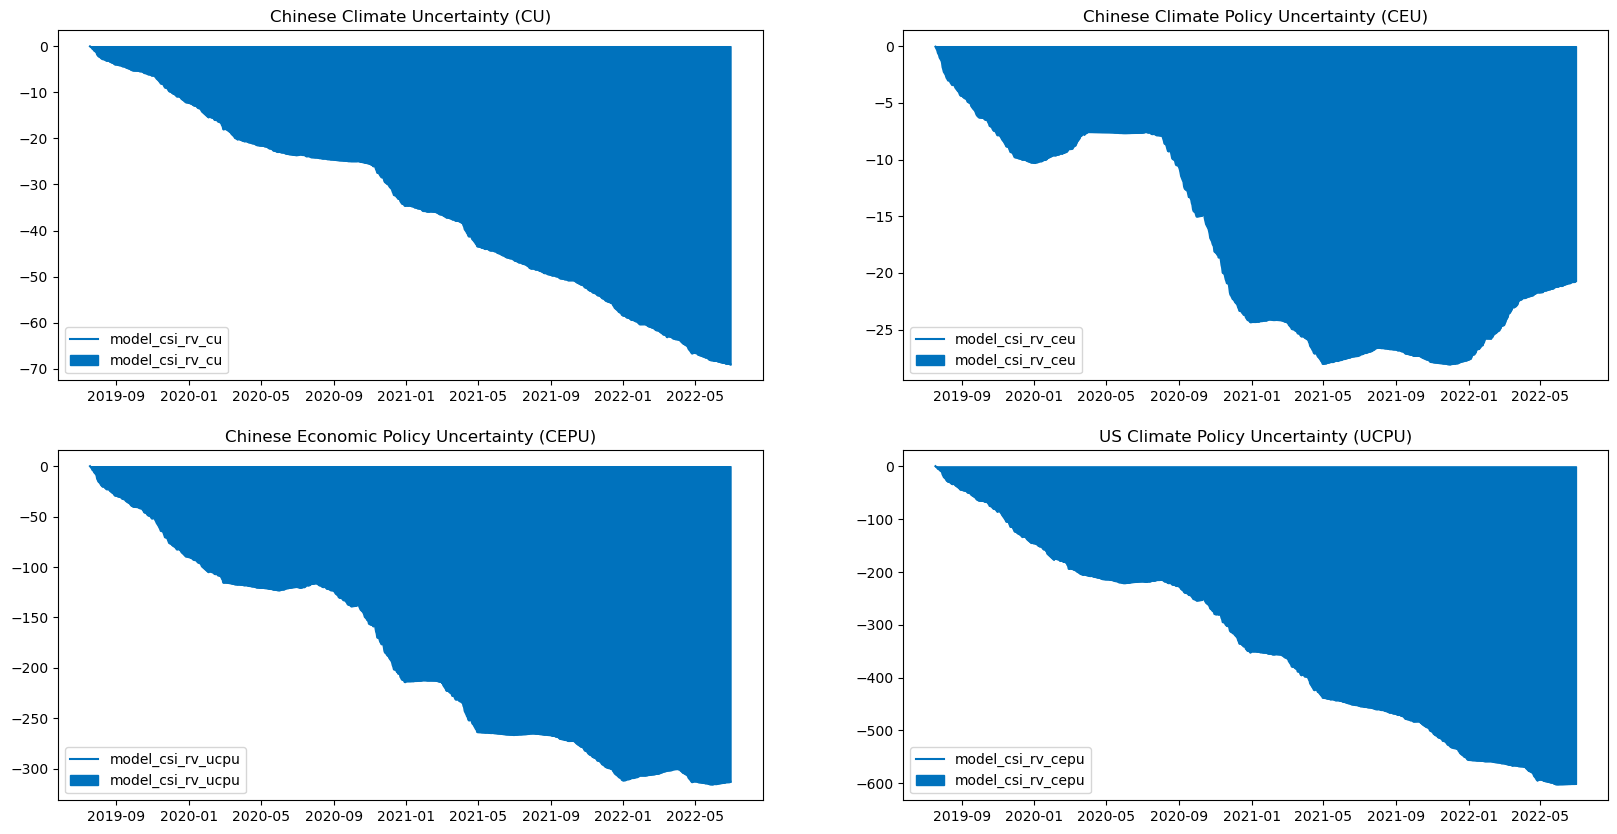

In [48]:

fig, axs = plt.subplots(2, 2, figsize=(20,10))

color_scheme = (0/255,114/255,189/255) 

# Plot each line in its respective subplot
axs[0, 0].plot(cumSFE_lag9_dict['model_csi_rv_cu']['date'], cumSFE_lag9_dict['model_csi_rv_cu']['CSFE'], color = color_scheme, label='model_csi_rv_cu')
axs[0, 0].fill_between(cumSFE_lag9_dict['model_csi_rv_cu']['date'], cumSFE_lag9_dict['model_csi_rv_cu']['CSFE'], color = color_scheme, label='model_csi_rv_cu')
axs[0, 0].set_title('Chinese Climate Uncertainty (CU)')
axs[0, 0].legend(loc = 'lower left')

axs[0, 1].plot(cumSFE_lag9_dict['model_csi_rv_cu']['date'], cumSFE_lag9_dict['model_csi_rv_ceu']['CSFE'], color = color_scheme, label='model_csi_rv_ceu')
axs[0, 1].fill_between(cumSFE_lag9_dict['model_csi_rv_cu']['date'], cumSFE_lag9_dict['model_csi_rv_ceu']['CSFE'], color = color_scheme, label='model_csi_rv_ceu')
axs[0, 1].set_title('Chinese Climate Policy Uncertainty (CEU)')
axs[0, 1].legend(loc = 'lower left')

axs[1, 0].plot(cumSFE_lag9_dict['model_csi_rv_cu']['date'], cumSFE_lag9_dict['model_csi_rv_ucpu']['CSFE'], color = color_scheme, label='model_csi_rv_ucpu')
axs[1, 0].fill_between(cumSFE_lag9_dict['model_csi_rv_cu']['date'], cumSFE_lag9_dict['model_csi_rv_ucpu']['CSFE'], color = color_scheme, label='model_csi_rv_ucpu')
axs[1, 0].set_title('Chinese Economic Policy Uncertainty (CEPU)')
axs[1, 0].legend(loc = 'lower left')

axs[1, 1].plot(cumSFE_lag9_dict['model_csi_rv_cu']['date'], cumSFE_lag9_dict['model_csi_rv_cepu']['CSFE'], color=color_scheme, label='model_csi_rv_cepu')
axs[1, 1].fill_between(cumSFE_lag9_dict['model_csi_rv_cu']['date'], cumSFE_lag9_dict['model_csi_rv_cepu']['CSFE'], color=color_scheme, label='model_csi_rv_cepu')
axs[1, 1].set_title('US Climate Policy Uncertainty (UCPU)')
axs[1, 1].legend(loc = 'lower left')

# Adjust layout

# Show the plot
plt.show()

## Forecasting from Jul2022 to Jan2023

Decided on lag k = 9 to be the "best" at replicating the paper's results


Reworking the g function to forecast for Jul2022 - Jan2023

In [49]:
# Attempt 1 assumes we back into rit and tau from lnret100 and lntau respectively
def calculate_g2(modelparamsdf, exogdf10, all_df, initial_g_df, k):

    # Let n = length of forecast period (in days)

    # Set first date of forecast: [This is the TRADING DAY after g0 date]
    forecast_start_date = dt.datetime(2022, 7, 1) # changed to match period for forecasting

    # Set last date of forecast
    forecast_end_date = dt.datetime(2023, 1, 31)

    global forecast_git_dict
    forecast_git_dict = {}

    for model in modelparamsdf['model']:
        globals()[model+'forecasttestdf'] = forecast(model, modelparamsdf, exogdf10, all_df, k)

        # global globals()[model+'forecasttestdf'] 
        # Extract g0 from initial_g_df
        g0 = initial_g_df.loc[initial_g_df['Model'] == model]['g0'].values[0]

        # Extract fitted GARCH MIDAS parameters
        mu = modelparamsdf.loc[modelparamsdf['model'] == model]['mu'].values[0] 
        alpha = modelparamsdf.loc[modelparamsdf['model'] == model]['alpha'].values[0] 
        beta = modelparamsdf.loc[modelparamsdf['model'] == model]['beta'].values[0] 

        # Extract from forecasttestdf (all_results_df)
        all_results_df
    
        # Extract lnret100
        temp_underlying_data = str(model).split('_')[1] # Checks csi or ssec
        if temp_underlying_data == 'csi':
            #lnret100 = all_results_df.loc[(all_results_df['date'] >= forecast_start_date) & (all_results_df['date'] <= forecast_end_date)]['csi_lnret100']
            lnret100 = all_results_df.iloc[1215:1356]['csi_lnret100']
        else:
            #lnret100 = all_results_df.loc[(all_results_df['date'] >= forecast_start_date) & (all_results_df['date'] <= forecast_end_date)]['ssec_lnret100']
            lnret100 = all_results_df.iloc[1215:1356]['ssec_lnret100']

        # Calculate rit
        lnret100 = np.array(lnret100) # Convert to array to perform vector operations
#######################################        
        rit = (lnret100 / 100) # To back into ri,t, first divide by 100
#######################################
                
        # Extract lnTau
        lntau = all_results_df.loc[(all_results_df['date'] >= forecast_start_date) & (all_results_df['date'] <= forecast_end_date)]['lntau']
        lntau = np.array(lntau) # Convert to array to perform vector operations
        
#######################################
        tau = np.exp(lntau) #  generated lntau, taking exponent to generate tau
#######################################
        # Initialise list
        git_list = []

        # Set up for loop to loop through each day of forecast period, calculating and appending git
        for i in range(len(rit)):
            if i == 0: # uses g0 for first iteration
                git = (1 - alpha - beta) + alpha * ( ((rit[i] - mu)**2) / tau[i] ) + beta * g0
                git_list.append(git)
            else:
                git = (1 - alpha - beta) + alpha * ( ((rit[i] - mu)**2) / tau[i] ) + beta * git_list[-1]
                git_list.append(git)

        forecast_git_dict[model] = git_list

        # globals()[model+'_git_df'] = pd.DataFrame(dict(date = all_results_df.loc[(all_results_df['date'] >= forecast_start_date) & (all_results_df['date'] <= forecast_end_date)]['date'], g = np.array(git_list)))

    return forecast_git_dict

In [50]:
# Forecasting

forecast_startindex = 1215
forecast_endindex = 1355+1

forecast_dict = {}

forecast_modelparamsdf = pd.read_excel('allData090324Forecast.xlsx', sheet_name=f'model_params_k9')
forecast_exogdf = pd.read_excel('allData090324Forecast.xlsx', sheet_name='exog')
forecast_df = pd.read_excel('allData090324Forecast.xlsx', sheet_name ='all')

# lntau_dict
forecast_lntau_dict = {}
for model in forecast_modelparamsdf['model']:
    resultdf = forecast(model, forecast_modelparamsdf, forecast_exogdf, forecast_df, K=9)
    forecast_lntau_dict[model] = resultdf

print('lntau done!')


# calculate short term component (g)
initial_g_df = pd.read_csv('initial_g.csv')
initial_g_df = initial_g_df.rename(columns = {initial_g_df.columns[0]:'Model',initial_g_df.columns[1]:'g0'})

# generate git
calculate_g2(forecast_modelparamsdf, forecast_exogdf, forecast_df, initial_g_df, 9)

# calculate short term component (g)
initial_g_df = pd.read_csv('initial_g.csv')
initial_g_df = initial_g_df.rename(columns = {initial_g_df.columns[0]:'Model',initial_g_df.columns[1]:'g0'})

# generate git
calculate_g2(forecast_modelparamsdf, forecast_exogdf, forecast_df, initial_g_df, 9)
# global forecast_git_dict generated

forecast_sigmahat_dict = {}

for model in forecast_modelparamsdf['model']:
    tau = np.exp(forecast_lntau_dict[model]['lntau'].iloc[forecast_startindex:forecast_endindex]) # must put in the rows for the forecast period
    git = forecast_git_dict[model] 
    forecast_sigmahat_dict[model] = np.sqrt(tau*git)

print('sigmahat done!')

lntau done!
sigmahat done!


In [51]:
pd.DataFrame(forecast_sigmahat_dict)

,model_csi_rv_cu,model_csi_rv_ceu,model_csi_rv_cepu,model_csi_rv_ucpu,model_ssec_rv_cu,model_ssec_rv_ceu,model_ssec_rv_cepu,model_ssec_rv_ucpu,model_csi_rv,model_ssec_rv
1215,1.281007,1.292610,1.402444,1.432010,1.601920,1.588532,1.439395,1.425315,1.295891,1.409808
1216,1.302182,1.316421,1.419552,1.444234,1.625792,1.616358,1.448523,1.401030,1.317859,1.407659
1217,1.319442,1.335728,1.433260,1.454315,1.644638,1.638755,1.456252,1.377314,1.335686,1.405831
1218,1.333550,1.351435,1.444269,1.462639,1.659559,1.656840,1.462803,1.354154,1.350194,1.404273
1219,1.345110,1.364244,1.453126,1.469521,1.671399,1.671480,1.468358,1.331554,1.362030,1.402960
...,...,...,...,...,...,...,...,...,...,...
1351,1.348326,1.405691,0.818396,1.107551,1.351417,1.055668,0.689766,0.318930,1.404732,1.122435
1352,1.348326,1.405691,0.818396,1.107551,1.351417,1.055668,0.689766,0.318788,1.404732,1.122434
1353,1.348326,1.405691,0.818396,1.107551,1.351417,1.055668,0.689766,0.318623,1.404732,1.122422
1354,1.348326,1.405691,0.818396,1.107551,1.351417,1.055668,0.689766,0.318472,1.404732,1.122415


In [52]:
### Comparing R_oos for Jul2022 to Jul 2023

# getting sigmat 
forecast_sigmat = pd.read_excel('allData090324Forecast.xlsx')
forecast_sigmat = forecast_sigmat[['date', 'ssec_lnret100', 'csi_lnret100']]
forecast_sigmat = forecast_sigmat.iloc[forecast_startindex:forecast_endindex] # put in the start and stop index for forecast period

forecast_R_oos = {}

for model in forecast_modelparamsdf['model']:
    if model.split('_')[1] == 'csi':
        actual = forecast_sigmat['csi_lnret100']
    else: 
        actual = forecast_sigmat['ssec_lnret100']
    hat = forecast_sigmahat_dict[model]
    bench_name_list = model.split('_')
    bench_name = bench_name_list[0]+'_'+bench_name_list[1]+'_'+bench_name_list[2]
    bench = forecast_sigmahat_dict[bench_name]

    forecast_R_oos[model] = r_squared_OOS(actual, hat, bench)

print('R_oos done!')

R_oos done!


In [53]:
forecast_R_oos

{'model_csi_rv_cu': 0.02653362995817732,
 'model_csi_rv_ceu': 0.0057815468493028765,
 'model_csi_rv_cepu': 0.18239812613954243,
 'model_csi_rv_ucpu': 0.082693712610179,
 'model_ssec_rv_cu': -0.3117422463335504,
 'model_ssec_rv_ceu': -0.06328667449191827,
 'model_ssec_rv_cepu': 0.11397435030721736,
 'model_ssec_rv_ucpu': 0.45145796991518106,
 'model_csi_rv': 0.0,
 'model_ssec_rv': 0.0}

In [54]:
### Comparing MSPE_Adj for Jul2022 to Jan 2023

# getting sigmat 
forecast_sigmat = pd.read_excel('allData090324Forecast.xlsx')
forecast_sigmat = forecast_sigmat[['date', 'ssec_lnret100', 'csi_lnret100']]
forecast_sigmat = forecast_sigmat.iloc[forecast_startindex:forecast_endindex] # put in the start and stop index for forecast period

forecast_MSPE_Adj_dict = {}

for model in forecast_modelparamsdf['model']:
    if model.split('_')[1] == 'csi':
        actual = forecast_sigmat['csi_lnret100']
    else: 
        actual = forecast_sigmat['ssec_lnret100']
    hat = forecast_sigmahat_dict[model]
    bench_name_list = model.split('_')
    bench_name = bench_name_list[0]+'_'+bench_name_list[1]+'_'+bench_name_list[2]
    bench = forecast_sigmahat_dict[bench_name]

    forecast_MSPE_Adj_dict[model] = MSPE_Adj(actual, hat, bench)

print('MSPE_Adj Done!')

MSPE_Adj Done!


In [55]:
forecast_MSPE_Adj_dict

{'model_csi_rv_cu': 0.09028554832304314,
 'model_csi_rv_ceu': 0.01947533158967829,
 'model_csi_rv_cepu': 0.8201358025209919,
 'model_csi_rv_ucpu': 0.3425271731357946,
 'model_ssec_rv_cu': -0.7055681493697907,
 'model_ssec_rv_ceu': -0.12310923299766063,
 'model_ssec_rv_cepu': 0.36551657750930167,
 'model_ssec_rv_ucpu': 1.6075544641558965,
 'model_csi_rv': 0.0,
 'model_ssec_rv': 0.0}

## Forecasting Stock Volatility using Random Forest & Other Machine Learning Algorithms 

In [56]:
# Import dependencies
# Bagging algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

# Boosting algorithms
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Support Vector Machine
from sklearn.svm import SVR

# For model selection / cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error

In [57]:
# Required - interpolation date range
SSEC_full_df = pd.read_excel('SSEC Index.xlsx')
SSEC_full_df = SSEC_full_df[['date','close']].rename(columns = {'date':'Date','close':'SSEC'}).set_index('Date')
SSEC_full_df = SSEC_full_df.loc[(SSEC_full_df.index >= dt.datetime(2017,1,1)) & (SSEC_full_df.index <= dt.datetime(2023,1,3))]
SSEC_full_df

,SSEC
Date,
2017-01-03,3135.92
2017-01-04,3158.79
2017-01-05,3165.41
2017-01-06,3154.32
2017-01-09,3171.24
...,...
2022-12-27,3095.57
2022-12-28,3087.40
2022-12-29,3073.70


In [58]:
# Generate ml_df
ml_df = forecast_df.copy()
# Convert LnRet100 used in R back to LnRet for ML
ml_df['ssec_lnret'] = ml_df['ssec_lnret100'] / 100
ml_df['csi_lnret'] = ml_df['csi_lnret100'] / 100
# Note: CPU indices columns already represent (monthly) LnRet on CPU indices
# Drop lnret100 columns
ml_df = ml_df.drop(['ssec_lnret100', 'csi_lnret100'], axis = 1)
ml_df

,date,year_month,csi,ssec,CU,CEU,CEPU,UCPU,ssec_RV,csi_RV,ssec_lnret,csi_lnret
0,2017-07-03,2017-07-01,992.84,3195.91,0.539557,0.034537,-0.702833,-0.291961,6.233673,9.920652,0.001089,-0.007186
1,2017-07-04,2017-07-01,983.06,3182.80,0.539557,0.034537,-0.702833,-0.291961,6.233673,9.920652,-0.004111,-0.009899
2,2017-07-05,2017-07-01,996.56,3207.13,0.539557,0.034537,-0.702833,-0.291961,6.233673,9.920652,0.007615,0.013639
3,2017-07-06,2017-07-01,997.57,3212.44,0.539557,0.034537,-0.702833,-0.291961,6.233673,9.920652,0.001654,0.001013
4,2017-07-07,2017-07-01,993.67,3217.96,0.539557,0.034537,-0.702833,-0.291961,6.233673,9.920652,0.001717,-0.003917
...,...,...,...,...,...,...,...,...,...,...,...,...
1351,2023-01-18,2023-01-01,1141.98,3224.41,0.409903,-0.524454,0.038534,0.073250,5.319786,11.688608,0.000053,-0.001715
1352,2023-01-19,2023-01-01,1148.91,3240.28,0.409903,-0.524454,0.038534,0.073250,5.319786,11.688608,0.004910,0.006050
1353,2023-01-20,2023-01-01,1156.15,3264.81,0.409903,-0.524454,0.038534,0.073250,5.319786,11.688608,0.007542,0.006282
1354,2023-01-30,2023-01-01,1162.22,3269.32,0.409903,-0.524454,0.038534,0.073250,5.319786,11.688608,0.001380,0.005236


In [59]:
# Drop unnecessary columns
ml_df = ml_df[['date','year_month','ssec_lnret','csi_lnret']]
ml_df

,date,year_month,ssec_lnret,csi_lnret
0,2017-07-03,2017-07-01,0.001089,-0.007186
1,2017-07-04,2017-07-01,-0.004111,-0.009899
2,2017-07-05,2017-07-01,0.007615,0.013639
3,2017-07-06,2017-07-01,0.001654,0.001013
4,2017-07-07,2017-07-01,0.001717,-0.003917
...,...,...,...,...
1351,2023-01-18,2023-01-01,0.000053,-0.001715
1352,2023-01-19,2023-01-01,0.004910,0.006050
1353,2023-01-20,2023-01-01,0.007542,0.006282
1354,2023-01-30,2023-01-01,0.001380,0.005236


In [60]:
# 1460 interpolation points
SSEC_full_df_filtered = SSEC_full_df.loc[SSEC_full_df.index <= dt.datetime(2023,1,3)]
SSEC_full_df_filtered

,SSEC
Date,
2017-01-03,3135.92
2017-01-04,3158.79
2017-01-05,3165.41
2017-01-06,3154.32
2017-01-09,3171.24
...,...
2022-12-27,3095.57
2022-12-28,3087.40
2022-12-29,3073.70


In [61]:
# CSI_RV_df - for ML
CSI_RV_df = CSI_df.copy().reset_index()
CSI_RV_df['year_month'] = CSI_RV_df['Date'].apply(lambda x: dt.datetime(x.year,x.month,1))
CSI_RV_df = CSI_RV_df.set_index('Date')
CSI_RV_df['CSI SquaredRet'] = CSI_RV_df['CSI LnRet'] ** 2
CSI_RV_df = CSI_RV_df.groupby('year_month').agg(sum)
CSI_RV_df = CSI_RV_df[['CSI SquaredRet']].reset_index().rename(columns = {'year_month':'Date','CSI SquaredRet':'CSI_RV'}).set_index('Date')
CSI_RV_df = CSI_RV_df.loc[CSI_RV_df.index <= dt.datetime(2023,1,1)]
CSI_RV_df

,CSI_RV
Date,
2017-07-01,0.000992
2017-08-01,0.001435
2017-09-01,0.000184
2017-10-01,0.000613
2017-11-01,0.002758
...,...
2022-09-01,0.001727
2022-10-01,0.003568
2022-11-01,0.005162


In [62]:
# SSEC_RV_df - for ML
SSEC_RV_df = SSEC_df.copy().reset_index()
SSEC_RV_df['year_month'] = SSEC_RV_df['Date'].apply(lambda x: dt.datetime(x.year,x.month,1))
SSEC_RV_df = SSEC_RV_df.set_index('Date')
SSEC_RV_df['SSEC SquaredRet'] = SSEC_RV_df['SSEC LnRet'] ** 2
SSEC_RV_df = SSEC_RV_df.groupby('year_month').agg(sum)
SSEC_RV_df = SSEC_RV_df[['SSEC SquaredRet']].reset_index().rename(columns = {'year_month':'Date','SSEC SquaredRet':'SSEC_RV'}).set_index('Date')
SSEC_RV_df = SSEC_RV_df.loc[SSEC_RV_df.index <= dt.datetime(2023,1,1)]
SSEC_RV_df

,SSEC_RV
Date,
2017-07-01,0.000623
2017-08-01,0.001008
2017-09-01,0.000158
2017-10-01,0.000201
2017-11-01,0.001004
...,...
2022-09-01,0.001744
2022-10-01,0.002115
2022-11-01,0.002677


In [63]:
ml_df

,date,year_month,ssec_lnret,csi_lnret
0,2017-07-03,2017-07-01,0.001089,-0.007186
1,2017-07-04,2017-07-01,-0.004111,-0.009899
2,2017-07-05,2017-07-01,0.007615,0.013639
3,2017-07-06,2017-07-01,0.001654,0.001013
4,2017-07-07,2017-07-01,0.001717,-0.003917
...,...,...,...,...
1351,2023-01-18,2023-01-01,0.000053,-0.001715
1352,2023-01-19,2023-01-01,0.004910,0.006050
1353,2023-01-20,2023-01-01,0.007542,0.006282
1354,2023-01-30,2023-01-01,0.001380,0.005236


In [64]:
# Create individual ml_index_df 
index_list = ['CU','CEU','CEPU','UCPU']

for each_index in index_list:
    globals()['ml_'+each_index+'_df'] = globals()[each_index+'_df'].loc[(globals()[each_index+'_df'].index >= dt.datetime(2017,1,1)) & (globals()[each_index+'_df'].index <= dt.datetime(2023,1,1))]

In [65]:
# Determine no. of trading days between 2 dates in preparation for interpolation # 1460 

print(len(SSEC_full_df.loc[SSEC_full_df.index <= dt.datetime(2023,1,3)])) # 1460 interpolation points

from scipy.interpolate import CubicSpline

# Initialise dictionaries to store result
index_cs_dict = {}
index_original_dict = {}

# Existing points
for each_index in index_list:
    x = np.arange(len(globals()['ml_'+each_index+'_df'].loc[globals()['ml_'+each_index+'_df'].index <= dt.datetime(2023,1,3)])) # 73 points
    # Extract each index's LnRet
    y = globals()['ml_'+each_index+'_df'][each_index+' LnRet']

    # Create the cubic spline interpolation
    cs = CubicSpline(x, y)

    # Generate points for plotting the interpolated curve
    x_interp = np.linspace(0, 72, 1460)
    y_interp = cs(x_interp)

    # Save interpolated index LnRet
    index_cs_dict[each_index] = y_interp

    # Also save original datapoints
    index_original_dict[each_index] = y

# Save Cubic-Spline interpolated indices to DF
index_original_df = pd.DataFrame(index_original_dict)
index_cs_df = pd.DataFrame(index_cs_dict)
index_cs_df


1460


,CU,CEU,CEPU,UCPU
0,-0.515747,-0.277637,0.071486,0.109569
1,-0.817595,-0.063378,-0.036599,0.104159
2,-1.077545,0.131920,-0.132972,0.098746
3,-1.297411,0.308895,-0.218113,0.093322
4,-1.479004,0.468188,-0.292500,0.087882
...,...,...,...,...
1455,0.056572,-0.747939,-0.163234,-0.008017
1456,0.134611,-0.633867,-0.121509,0.009777
1457,0.219352,-0.499041,-0.074124,0.029222
1458,0.311036,-0.342484,-0.020853,0.050365


In [66]:
# Set Date column for index_cs_df
index_cs_df['Date'] = SSEC_full_df.index
index_cs_df = index_cs_df.set_index('Date')
index_cs_df

,CU,CEU,CEPU,UCPU
Date,,,,
2017-01-03,-0.515747,-0.277637,0.071486,0.109569
2017-01-04,-0.817595,-0.063378,-0.036599,0.104159
2017-01-05,-1.077545,0.131920,-0.132972,0.098746
2017-01-06,-1.297411,0.308895,-0.218113,0.093322
2017-01-09,-1.479004,0.468188,-0.292500,0.087882
...,...,...,...,...
2022-12-27,0.056572,-0.747939,-0.163234,-0.008017
2022-12-28,0.134611,-0.633867,-0.121509,0.009777
2022-12-29,0.219352,-0.499041,-0.074124,0.029222


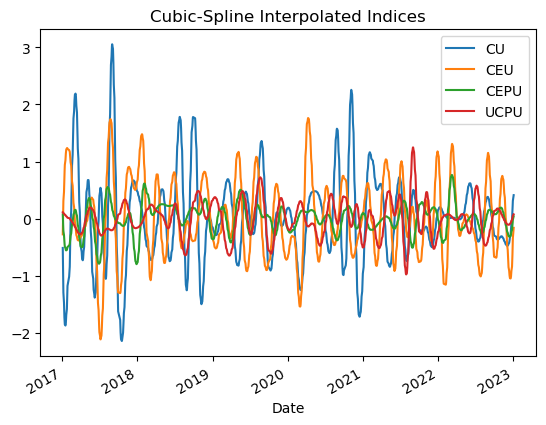

In [67]:
# Visualise!
index_cs_df.plot()
plt.title('Cubic-Spline Interpolated Indices')
plt.show()

In [68]:
# Required - Filter for date range
SSEC_full_df_filtered_for_RV = SSEC_full_df_filtered.loc[SSEC_full_df_filtered.index >= dt.datetime(2017,7,1)]
SSEC_full_df_filtered_for_RV

,SSEC
Date,
2017-07-03,3195.91
2017-07-04,3182.80
2017-07-05,3207.13
2017-07-06,3212.44
2017-07-07,3217.96
...,...
2022-12-27,3095.57
2022-12-28,3087.40
2022-12-29,3073.70


In [69]:
# Interpolate RVs
# Determine no. of trading days between 2 dates in preparation for interpolation # 1341

print(len(SSEC_full_df_filtered.loc[SSEC_full_df_filtered.index >= dt.datetime(2017,7,1)]))

from scipy.interpolate import CubicSpline

# Initialise dictionaries to store result
RV_cs_dict = {}
RV_original_dict = {}

data_list = ['SSEC','CSI']

# Existing points
for each in data_list:
    x = np.arange(len(globals()[each+'_RV_df'])) # 67 points
 
    # Extract each RV
    y = globals()[each+'_RV_df'][each+'_RV']

    # Create the cubic spline interpolation
    cs = CubicSpline(x, y)

    # Generate points for plotting the interpolated curve
    x_interp = np.linspace(0, 66, 1341)
    y_interp = cs(x_interp)

    # Save interpolated RV 
    RV_cs_dict[each+'_RV'] = y_interp

    # Also save original datapoints
    RV_original_dict[each+"_RV"] = y

# Save Cubic-Spline interpolated RVs to DF
RV_original_df = pd.DataFrame(RV_original_dict)
RV_cs_df = pd.DataFrame(RV_cs_dict)
RV_cs_df


1341


,SSEC_RV,CSI_RV
0,0.000623,0.000992
1,0.000711,0.001112
2,0.000789,0.001219
3,0.000859,0.001313
4,0.000920,0.001395
...,...,...
1336,0.000369,0.000404
1337,0.000392,0.000544
1338,0.000427,0.000718
1339,0.000473,0.000925


In [70]:
# Set Date column for RV_cs_df
RV_cs_df['Date'] = SSEC_full_df_filtered_for_RV.index
RV_cs_df = RV_cs_df.set_index('Date')
RV_cs_df

,SSEC_RV,CSI_RV
Date,,
2017-07-03,0.000623,0.000992
2017-07-04,0.000711,0.001112
2017-07-05,0.000789,0.001219
2017-07-06,0.000859,0.001313
2017-07-07,0.000920,0.001395
...,...,...
2022-12-27,0.000369,0.000404
2022-12-28,0.000392,0.000544
2022-12-29,0.000427,0.000718


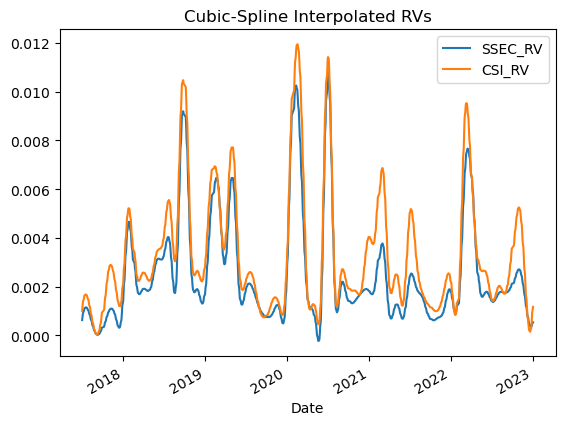

In [71]:
# Visualise!
RV_cs_df.plot()
plt.title('Cubic-Spline Interpolated RVs')
plt.show()

In [72]:
# Filter this to begin from Jul 2017 due to the RV bottleneck
index_cs_df = index_cs_df.loc[index_cs_df.index >= dt.datetime(2017,7,1)]
index_cs_df

,CU,CEU,CEPU,UCPU
Date,,,,
2017-07-03,0.467579,-2.054560,-0.770122,-0.269682
2017-07-04,0.515636,-2.096696,-0.749639,-0.279970
2017-07-05,0.538743,-2.118668,-0.722188,-0.288189
2017-07-06,0.534101,-2.118687,-0.687470,-0.294174
2017-07-07,0.501585,-2.096388,-0.645644,-0.297909
...,...,...,...,...
2022-12-27,0.056572,-0.747939,-0.163234,-0.008017
2022-12-28,0.134611,-0.633867,-0.121509,0.009777
2022-12-29,0.219352,-0.499041,-0.074124,0.029222


In [73]:
# Set Date as index for ml_df
ml_df = ml_df.rename(columns = {'date':'Date'}).set_index('Date')
ml_df

,year_month,ssec_lnret,csi_lnret
Date,,,
2017-07-03,2017-07-01,0.001089,-0.007186
2017-07-04,2017-07-01,-0.004111,-0.009899
2017-07-05,2017-07-01,0.007615,0.013639
2017-07-06,2017-07-01,0.001654,0.001013
2017-07-07,2017-07-01,0.001717,-0.003917
...,...,...,...
2023-01-18,2023-01-01,0.000053,-0.001715
2023-01-19,2023-01-01,0.004910,0.006050
2023-01-20,2023-01-01,0.007542,0.006282


In [74]:
# Before lags - Master copy
ml_master_df = pd.concat([ml_df,index_cs_df,RV_cs_df], axis = 1)
ml_master_df

,year_month,ssec_lnret,csi_lnret,CU,CEU,CEPU,UCPU,SSEC_RV,CSI_RV
Date,,,,,,,,,
2017-07-03,2017-07-01,0.001089,-0.007186,0.467579,-2.054560,-0.770122,-0.269682,0.000623,0.000992
2017-07-04,2017-07-01,-0.004111,-0.009899,0.515636,-2.096696,-0.749639,-0.279970,0.000711,0.001112
2017-07-05,2017-07-01,0.007615,0.013639,0.538743,-2.118668,-0.722188,-0.288189,0.000789,0.001219
2017-07-06,2017-07-01,0.001654,0.001013,0.534101,-2.118687,-0.687470,-0.294174,0.000859,0.001313
2017-07-07,2017-07-01,0.001717,-0.003917,0.501585,-2.096388,-0.645644,-0.297909,0.000920,0.001395
...,...,...,...,...,...,...,...,...,...
2023-01-18,2023-01-01,0.000053,-0.001715,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-19,2023-01-01,0.004910,0.006050,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-20,2023-01-01,0.007542,0.006282,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
# Generate DFs for ML
# Assume 21 trading days in a month
month_lag = 21
# No. of lags (in months)
K = 6

for model in modelparamsdf['model']:
    if model.split('_')[1] == 'csi':
        # Concatenate with lagged versions of RV

        # Create lagged RVs
        lagged_RV_df = pd.concat([ml_master_df['CSI_RV'].shift(i*month_lag) for i in range(1,K + 1)], axis = 1)
        # Rename columns
        lagged_RV_df.columns = ['CSI_RV_lag_'+str(i) for i in range(1,K + 1)]
        # Concatenate with csi_lnret
        globals()['ml_'+model] = pd.concat([ml_master_df['csi_lnret'], lagged_RV_df], axis = 1)
        
    
    else:
        # Concatenate with lagged versions of RV

        # Create lagged RVs
        lagged_RV_df = pd.concat([ml_master_df['SSEC_RV'].shift(i*month_lag) for i in range(1,K + 1)], axis = 1)
        # Rename columns
        lagged_RV_df.columns = ['SSEC_RV_lag_'+str(i) for i in range(1,K + 1)]
        # Concatenate with ssec_lnret
        globals()['ml_'+model] = pd.concat([ml_master_df['ssec_lnret'], lagged_RV_df], axis = 1) 

    # Checks for 2 variable MIDAS models
    if len(model.split('_')) > 3:
        # Define exog name
        exog = model.split('_')[3].upper()
        # Create lagged exog
        lagged_exog_df = pd.concat([ml_master_df[exog].shift(i*month_lag) for i in range(1,K + 1)], axis = 1)
        # Rename columns
        lagged_exog_df.columns = [exog+'_lag_'+str(i) for i in range(1,K + 1)]
        # Concatenate existing model df with lagged exog
        globals()['ml_'+model] = pd.concat([globals()['ml_'+model], lagged_exog_df], axis = 1)

    globals()['ml_'+model] = globals()['ml_'+model].dropna()

In [76]:
# Sample lagged exogenous variables set up for ML
ml_model_csi_rv_cu.head()

,csi_lnret,CSI_RV_lag_1,CSI_RV_lag_2,CSI_RV_lag_3,CSI_RV_lag_4,CSI_RV_lag_5,CSI_RV_lag_6,CU_lag_1,CU_lag_2,CU_lag_3,CU_lag_4,CU_lag_5,CU_lag_6
Date,,,,,,,,,,,,,
2018-01-03,0.004824,0.001766,0.002864,0.000821,0.000132,0.001399,0.000992,0.577053,-1.105531,-1.447794,3.025986,-1.045916,0.467579
2018-01-04,0.004240,0.001678,0.002882,0.000929,0.000102,0.001343,0.001112,0.604896,-0.993898,-1.627910,3.055510,-1.001235,0.515636
2018-01-05,0.002144,0.001593,0.002890,0.001043,0.000077,0.001283,0.001219,0.627273,-0.883907,-1.778450,3.037659,-0.919898,0.538743
2018-01-08,0.003777,0.001513,0.002888,0.001161,0.000058,0.001221,0.001313,0.644511,-0.775797,-1.900941,2.974467,-0.800469,0.534101
2018-01-09,0.009371,0.001439,0.002877,0.001282,0.000044,0.001157,0.001395,0.656934,-0.669805,-1.996958,2.869851,-0.646521,0.501585


In [77]:
# Let's do some machine learning!

# Settings for K Fold Cross Validation
num_folds = 10
seed = 100
scoring = "neg_mean_squared_error"

# Preparing ML models
models = []

# Ensemble Models
models.append(("RFR", RandomForestRegressor() ))
models.append(("ETR", ExtraTreesRegressor() ))
models.append(("GBR", GradientBoostingRegressor() ))
models.append(("ABR", AdaBoostRegressor() ))

# Support Vector Machine
models.append(("SVR", SVR() ))



# Create list to allow for iteration through models
ml_model_list = ['ml_'+ x for x in modelparamsdf['model']]



for ml_model in ml_model_list:

    # Initialise results dictionary to store ML results
    globals()[ml_model+'_results_dict'] = {}

    # Initialise dictionary to store predictions for each ml model and ml algo
    globals()[ml_model+'_predictions_dict'] = {}

    # Define Y (dependent variable)
    Y = globals()[ml_model].iloc[:,0]
    # Define X (independent/exogenous variables)
    X = globals()[ml_model].iloc[:,1:]

    # Train Test Split

    # Training Set: 3 Jan 2018 - 19 Jan 2022
    # Testing Set: 20 Jan 2022 - 31 Jan 2023
    
    validation_size = 0.20

    train_size = int(len(X) * (1 - validation_size))

    X_train , X_test = (X[0:train_size], X[train_size:len(X)]) # :984

    Y_train , Y_test = (Y[0:train_size], Y[train_size:len(X)]) # 984:


    globals()[ml_model+'_names'] = []
    globals()[ml_model+'_kfold_results'] = []
    globals()[ml_model+'_train_results'] = []
    globals()[ml_model+'_test_results'] = []

    # Print model name and divider
    print("-"*50)
    print(ml_model)

    for name, model in models:
        globals()[ml_model+'_names'].append(name)
        
        kfold = KFold(n_splits = num_folds, random_state = seed, shuffle = True)
        
        cv_results = (-1 * cross_val_score(model, X_train, Y_train, cv = kfold, scoring = scoring)) # x -1 because neg_mean_squared_error
        globals()[ml_model+'_kfold_results'].append(cv_results)
        
        globals()[ml_model+'_'+name+'_res'] = model.fit(X_train, Y_train)
        
        train_result = mean_squared_error(globals()[ml_model+'_'+name+'_res'].predict(X_train), Y_train)
        globals()[ml_model+'_train_results'].append(train_result)
        
        test_result = mean_squared_error(globals()[ml_model+'_'+name+'_res'].predict(X_test), Y_test)
        globals()[ml_model+'_test_results'].append(test_result)

        # Save predictions to dictionary
        # Predict Y_test using fitted model
        predicted_y = globals()[ml_model+'_'+name+'_res'].predict(X_test)
        globals()[ml_model+'_predictions_dict'][name] = predicted_y

        
        message = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
        
        
        print(message)

    # Store results in dictionary
    globals()[ml_model+'_results_dict']['models'] = globals()[ml_model+'_names']    
    globals()[ml_model+'_results_dict']['k_fold_results'] = globals()[ml_model+'_kfold_results']
    globals()[ml_model+'_results_dict']['train_results'] = globals()[ml_model+'_train_results']
    globals()[ml_model+'_results_dict']['test_results'] = globals()[ml_model+'_test_results']

    globals()[ml_model+'_predictions_df'] = pd.DataFrame( globals()[ml_model+'_predictions_dict']) 

--------------------------------------------------
ml_model_csi_rv_cu


RFR: 0.000211 (0.000033) 0.000031 0.000171
ETR: 0.000244 (0.000034) 0.000000 0.000171
GBR: 0.000191 (0.000040) 0.000104 0.000170
ABR: 0.000187 (0.000040) 0.000147 0.000181
SVR: 0.000300 (0.000062) 0.000307 0.000280
--------------------------------------------------
ml_model_csi_rv_ceu
RFR: 0.000207 (0.000032) 0.000031 0.000179
ETR: 0.000243 (0.000033) 0.000000 0.000172
GBR: 0.000187 (0.000037) 0.000099 0.000179
ABR: 0.000187 (0.000038) 0.000144 0.000177
SVR: 0.000300 (0.000062) 0.000307 0.000280
--------------------------------------------------
ml_model_csi_rv_cepu
RFR: 0.000211 (0.000032) 0.000030 0.000186
ETR: 0.000246 (0.000033) 0.000000 0.000169
GBR: 0.000189 (0.000037) 0.000103 0.000189
ABR: 0.000185 (0.000040) 0.000152 0.000167
SVR: 0.000300 (0.000062) 0.000307 0.000280
--------------------------------------------------
ml_model_csi_rv_ucpu
RFR: 0.000208 (0.000035) 0.000030 0.000349
ETR: 0.000240 (0.000032) 0.000000 0.000181
GBR: 0.000193 (0.000052) 0.000106 0.000327
ABR: 0.0001

In [78]:
# Create date index for predictions_df
predictions_index = ml_master_df.loc[(ml_master_df.index >= dt.datetime(2022,1,20))].index

dfs_to_concat = []

for ml_model in ml_model_list:
    globals()[ml_model+'_predictions_df']['Date'] = predictions_index
    globals()[ml_model+'_predictions_df'] = globals()[ml_model+'_predictions_df'].set_index('Date')

    dfs_to_concat.append(globals()[ml_model+'_predictions_df'])

consol_ml_predictions_df = pd.concat(dfs_to_concat, axis = 1, keys = modelparamsdf['model'])
consol_ml_predictions_df

model      model_csi_rv_cu                                          \
                       RFR       ETR       GBR       ABR       SVR   
Date                                                                 
2022-01-20       -0.002241 -0.004191 -0.000369 -0.000157 -0.011404   
2022-01-21       -0.001296 -0.001744  0.000706 -0.000157 -0.011404   
2022-01-24       -0.001297 -0.002750  0.000015 -0.000298 -0.011404   
2022-01-25       -0.000264 -0.002337  0.000937 -0.000298 -0.011404   
2022-01-26        0.001515 -0.002199  0.000937 -0.000298 -0.011404   
...                    ...       ...       ...       ...       ...   
2023-01-18       -0.000382  0.000522 -0.000697 -0.001222 -0.011404   
2023-01-19        0.001626  0.000260 -0.000697 -0.001222 -0.011404   
2023-01-20        0.001876  0.001213 -0.000697 -0.000298 -0.011404   
2023-01-30       -0.000138  0.000399 -0.000697 -0.000486 -0.011404   
2023-01-31        0.000506 -0.001235 -0.000697 -0.000486 -0.011404   

model      model_csi_rv_ceu                                          ...  \
                        RFR       ETR       GBR       ABR       SVR  ...   
Date                                                                 ...   
2022-01-20        -0.000524 -0.003138  0.000411 -0.001208 -0.011404  ...   
2022-01-21         0.000211 -0.001081  0.000460 -0.002225 -0.011404  ...   
2022-01-24         0.000731  0.000685  0.000230 -0.001120 -0.011404  ...   
2022-01-25         0.001143  0.001092  0.002106  0.000249 -0.011404  ...   
2022-01-26         0.001825  0.000981  0.002106  0.000249 -0.011404  ...   
...                     ...       ...       ...       ...       ...  ...   
2023-01-18         0.002838  0.001858 -0.000028  0.000373 -0.011404  ...   
2023-01-19         0.002369  0.002521  0.000922  0.000373 -0.011404  ...   
2023-01-20         0.000766  0.001509  0.000554  0.001640 -0.011404  ...   
2023-01-30        -0.001749 -0.000453  0.000439  0.000373 -0.011404  ...   
2023-01-31        -0.003450 -0.001473  0.000523  0.000249 -0.011404  ...   

model      model_csi_rv                                         model_ssec_rv  \
                    RFR       ETR       GBR       ABR       SVR           RFR   
Date                                                                            
2022-01-20    -0.000334 -0.006063  0.000071 -0.003447 -0.011404     -0.000975   
2022-01-21     0.000052 -0.004546  0.000071 -0.003307 -0.011404     -0.000488   
2022-01-24     0.000588 -0.005073  0.000071 -0.001947 -0.011404     -0.000503   
2022-01-25    -0.000035 -0.005458  0.000071 -0.001947 -0.011404     -0.000592   
2022-01-26     0.000770 -0.003385 -0.001277 -0.001947 -0.011404     -0.000499   
...                 ...       ...       ...       ...       ...           ...   
2023-01-18     0.002034  0.003272 -0.000753 -0.001633 -0.011404     -0.000189   
2023-01-19     0.001666  0.002988 -0.000024 -0.001633 -0.011404     -0.000626   
2023-01-20     0.000415  0.001449  0.000591  0.000489 -0.011404      0.000972   
2023-01-30    -0.000593  0.000557  0.000027  0.000489 -0.011404      0.001133   
2023-01-31    -0.000765 -0.000077  0.000489  0.000489 -0.011404      0.000697   

model                                               
                 ETR       GBR       ABR       SVR  
Date                                                
2022-01-20 -0.001873 -0.000573 -0.002695 -0.012424  
2022-01-21 -0.003242  0.000389 -0.002695 -0.012424  
2022-01-24 -0.001918  0.000389 -0.002695 -0.012424  
2022-01-25 -0.001643  0.000389 -0.002695 -0.012424  
2022-01-26 -0.000607  0.000389 -0.002695 -0.012424  
...              ...       ...       ...       ...  
2023-01-18  0.003121  0.000665  0.002027 -0.012424  
2023-01-19  0.001740  0.000665  0.002027 -0.012424  
2023-01-20  0.001984  0.001668  0.002027 -0.012424  
2023-01-30  0.001574  0.000926  0.001688 -0.012424  
2023-01-31  0.001350  0.001163  0.001688 -0.012424  

[246 rows x 50 columns]

In [79]:
# consol_ml_predictions_df.to_excel('consol_ml_predictions.xlsx')

In [80]:
ml_model_csi_rv_cu_predictions_df.columns

Index(['RFR', 'ETR', 'GBR', 'ABR', 'SVR'], dtype='object')

In [81]:
ml_master_df

,year_month,ssec_lnret,csi_lnret,CU,CEU,CEPU,UCPU,SSEC_RV,CSI_RV
Date,,,,,,,,,
2017-07-03,2017-07-01,0.001089,-0.007186,0.467579,-2.054560,-0.770122,-0.269682,0.000623,0.000992
2017-07-04,2017-07-01,-0.004111,-0.009899,0.515636,-2.096696,-0.749639,-0.279970,0.000711,0.001112
2017-07-05,2017-07-01,0.007615,0.013639,0.538743,-2.118668,-0.722188,-0.288189,0.000789,0.001219
2017-07-06,2017-07-01,0.001654,0.001013,0.534101,-2.118687,-0.687470,-0.294174,0.000859,0.001313
2017-07-07,2017-07-01,0.001717,-0.003917,0.501585,-2.096388,-0.645644,-0.297909,0.000920,0.001395
...,...,...,...,...,...,...,...,...,...
2023-01-18,2023-01-01,0.000053,-0.001715,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-19,2023-01-01,0.004910,0.006050,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-20,2023-01-01,0.007542,0.006282,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
ml_model_csi_rv_cu_predictions_df_select = ml_model_csi_rv_cu_predictions_df[['RFR', 'ETR', 'GBR', 'ABR']]

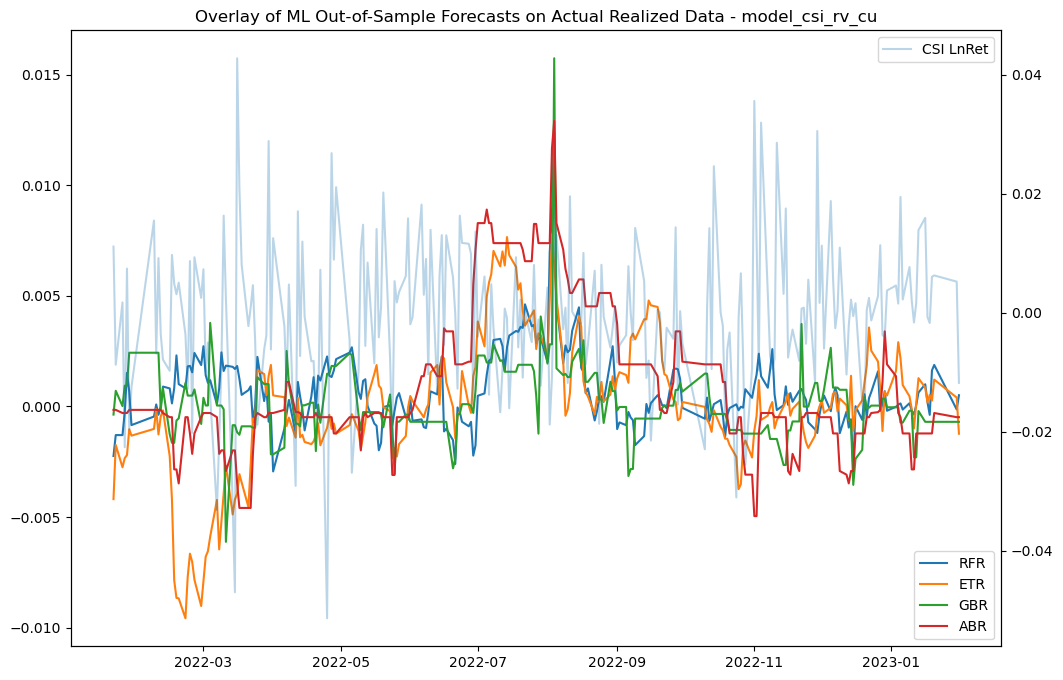

In [85]:
fig, ax = plt.subplots(figsize = (12,8))
ax2 = ax.twinx()
ax2.plot(ml_master_df.loc[(ml_master_df.index >= dt.datetime(2022,1,20))].index,ml_master_df.loc[(ml_master_df.index >= dt.datetime(2022,1,20))]['csi_lnret'], alpha = 0.3, label = 'CSI LnRet')
for each in ml_model_csi_rv_cu_predictions_df_select.columns:
    ax.plot(ml_model_csi_rv_cu_predictions_df_select.index, ml_model_csi_rv_cu_predictions_df_select[each], label = each)
plt.title('Overlay of ML Out-of-Sample Forecasts on Actual Realized Data - {}'.format(modelparamsdf['model'].iloc[0]))
ax.legend(loc = 'lower right')
ax2.legend()
plt.show()

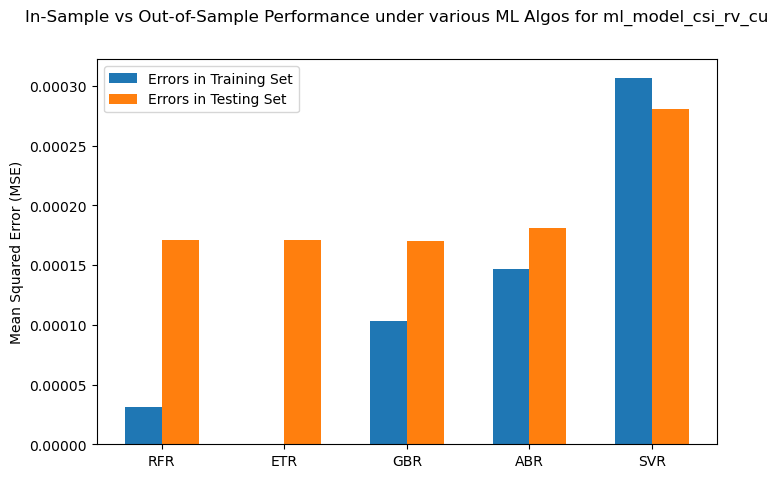

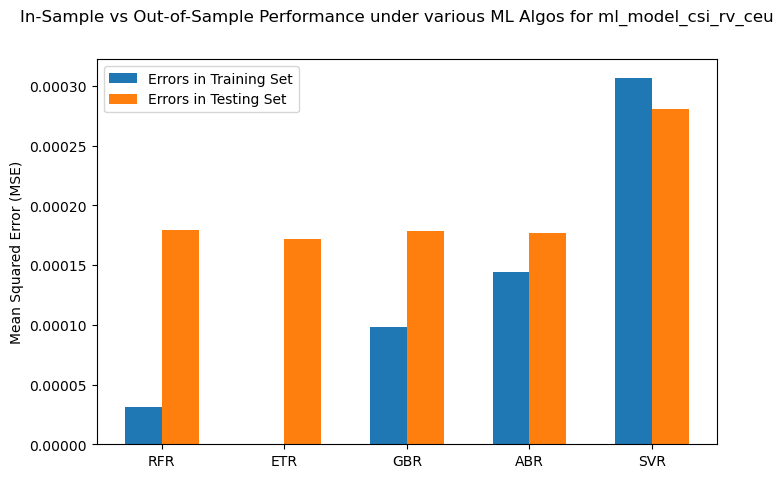

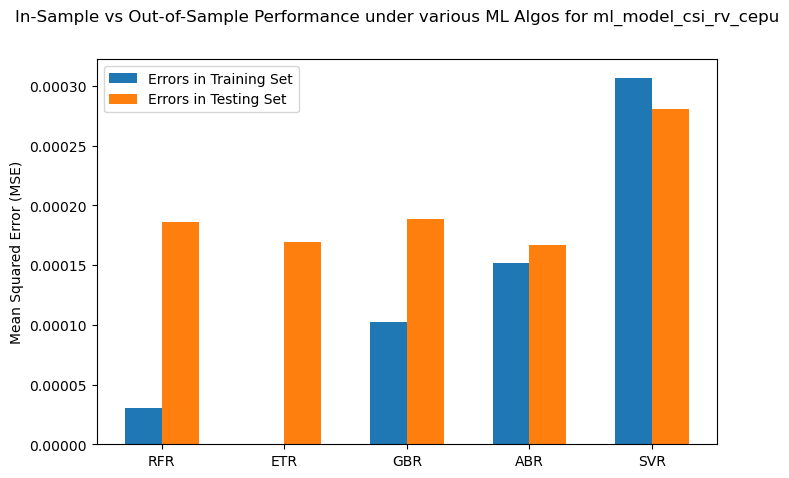

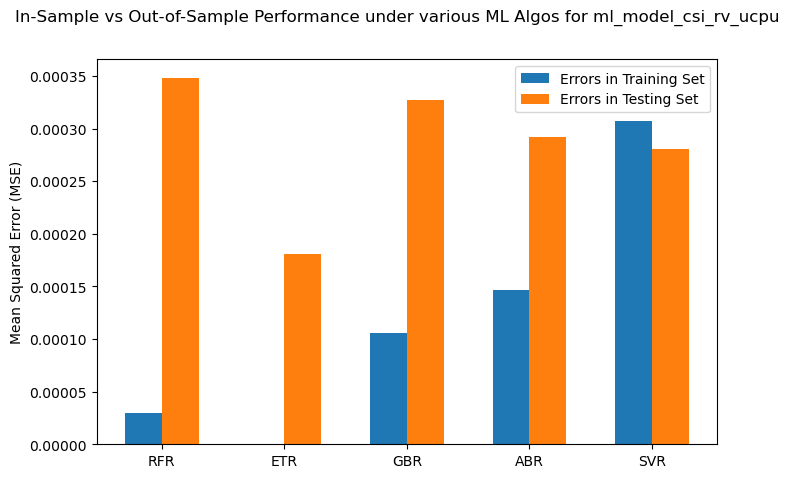

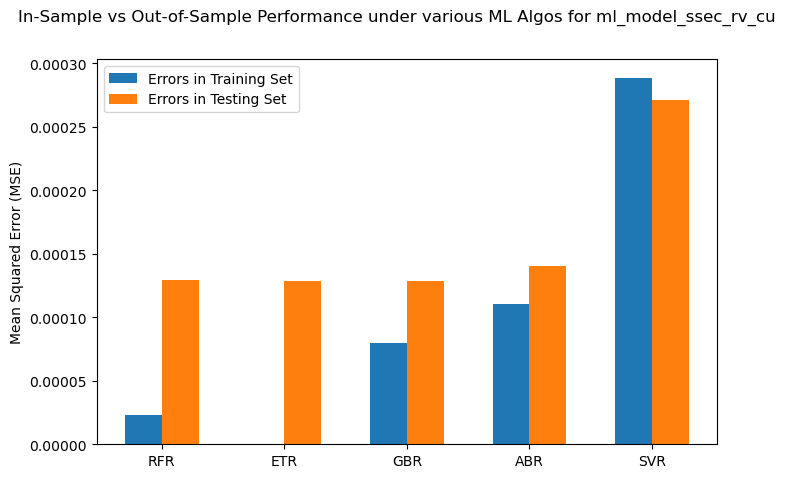

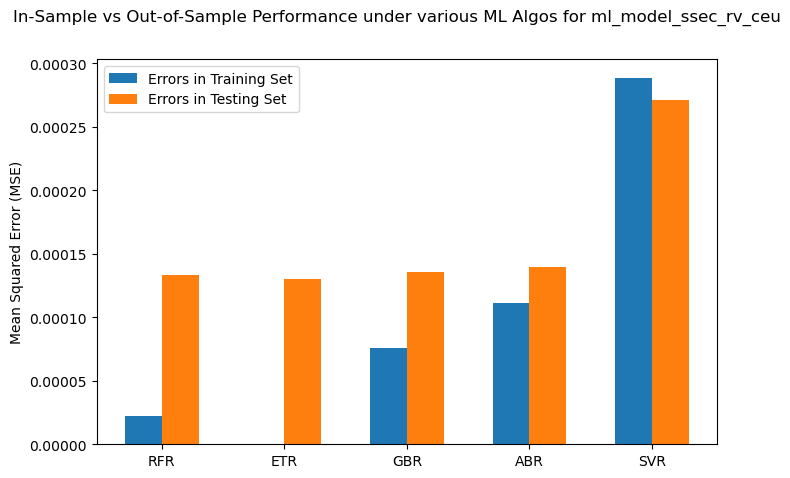

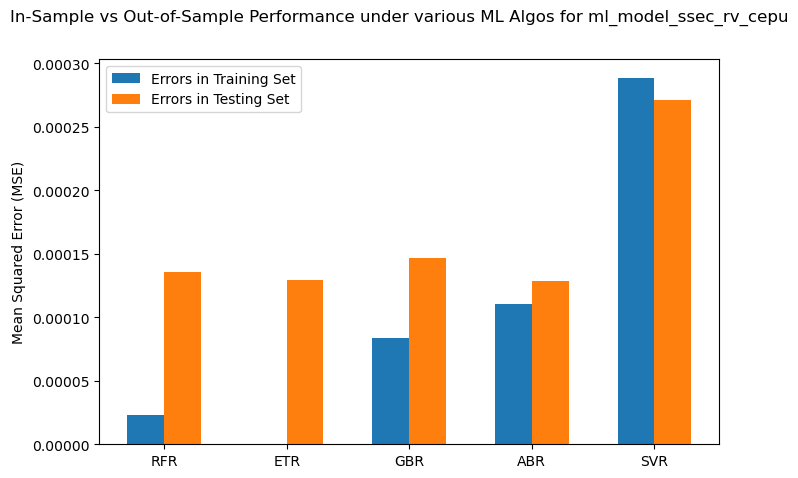

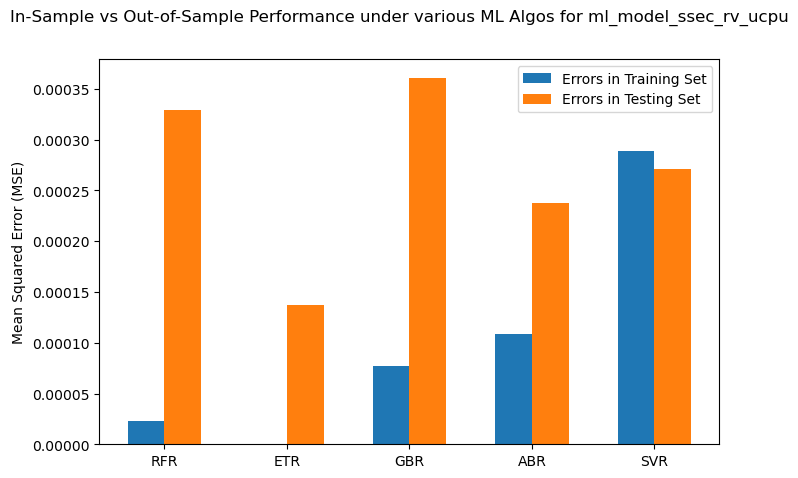

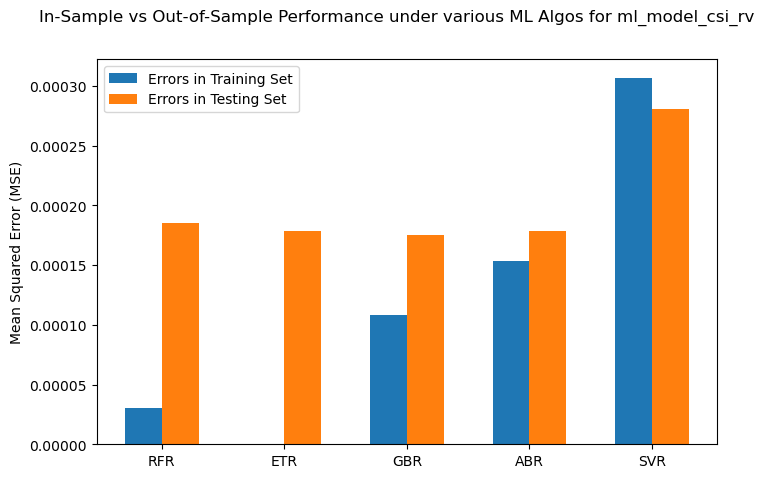

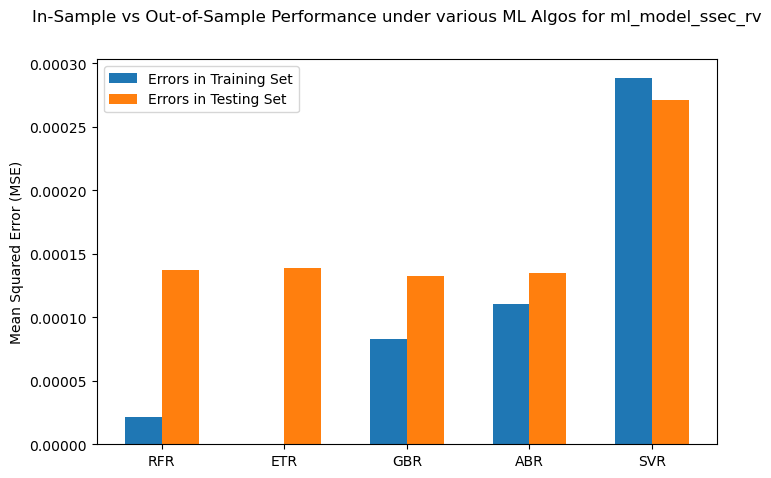

In [89]:
# Visualise results
for ml_model in ml_model_list:
    fig = plt.figure(figsize = [8, 5])

    ind = np.arange(len(globals()[ml_model+'_names']))
    width = 0.30
    fig.suptitle("In-Sample vs Out-of-Sample Performance under various ML Algos for {}".format(ml_model))

    ax = fig.add_subplot(111)

    (plt.bar(ind - width/2, globals()[ml_model+'_train_results'], width = width, label = "Errors in Training Set"))

    (plt.bar(ind + width/2, globals()[ml_model+'_test_results'],width = width, label = "Errors in Testing Set"))

    plt.legend()

    ax.set_xticks(ind)
    ax.set_xticklabels(globals()[ml_model+'_names'])

    plt.ylabel("Mean Squared Error (MSE)")

    plt.show()

In [120]:
ml_result = consol_ml_predictions_df.copy()
CSI_bmk = ml_result["model_csi_rv"]
SSEC_bmk = ml_result["model_ssec_rv"]
ml_date = np.array(ml_result.index)
ml_df1 = ml_df.copy()
# ml_df1 = ml_df.set_index("date")
ml_df1 = ml_df1[ml_df1.index>=dt.datetime(2022,1,20)]

In [121]:
def calculate_performance(model_name):
    model_components = model_name.split('_')
    if model_components[1].upper() == "CSI":
        sigma_bench = CSI_bmk
        sigma_actual = ml_df1["csi_lnret"]
    else:
        sigma_bench = SSEC_bmk
        sigma_actual = ml_df1["ssec_lnret"]
    new_df = ml_result[model_name]
    ML_Roos_Result_dict = {}
    ML_MSPE_Result_dict = {}
    ML_cumSFE_Result_dict = {}
    for i in ["RFR","ETR","GBR","ABR"]:
        Roos = r_squared_OOS(sigma_actual, new_df[i], sigma_bench[i])
        MSPE = MSPE_Adj(sigma_actual, new_df[i],sigma_bench[i])
        cum_SFE = cumSFE(sigma_actual, new_df[i], sigma_bench[i], ml_date)
        ML_Roos_Result_dict[i] = Roos
        ML_MSPE_Result_dict[i] = MSPE
        ML_cumSFE_Result_dict[i] = cum_SFE
    return ML_Roos_Result_dict, ML_MSPE_Result_dict, ML_cumSFE_Result_dict


In [122]:
ML_performance_metrix = {}
for model in modelparamsdf['model']:
    Roos = calculate_performance(model)[0]
    MSPE = calculate_performance(model)[1]
    ML_performance_metrix[model] = {"Roos": Roos,"MSPE_adj":MSPE}
ML_performance_metrix


{'model_csi_rv_cu': {'Roos': {'RFR': 0.07564371469053022,
   'ETR': 0.043955229711137744,
   'GBR': 0.029779054835914143,
   'ABR': -0.01450296215965774},
  'MSPE_adj': {'RFR': 2.0255436622000655e-05,
   'ETR': 1.89928704611957e-05,
   'GBR': 9.381781299826956e-06,
   'ABR': 4.291225203227367e-06}},
 'model_csi_rv_ceu': {'Roos': {'RFR': 0.0330125880015959,
   'ETR': 0.03828570196174752,
   'GBR': -0.021773946153918144,
   'ABR': 0.011205991072271604},
  'MSPE_adj': {'RFR': 2.0278284049804522e-05,
   'ETR': 2.229661946415821e-05,
   'GBR': 3.017082885047609e-06,
   'ABR': 1.2290550090504404e-05}},
 'model_csi_rv_cepu': {'Roos': {'RFR': -0.0036717979502542963,
   'ETR': 0.055640584132083726,
   'GBR': -0.07842599731875355,
   'ABR': 0.06610057541396253},
  'MSPE_adj': {'RFR': 1.0533419298772829e-05,
   'ETR': 1.992840147594052e-05,
   'GBR': 4.9910068673597965e-06,
   'ABR': 2.3435730124873628e-05}},
 'model_csi_rv_ucpu': {'Roos': {'RFR': -0.8806468651226496,
   'ETR': -0.010514747637475

In [123]:
# Convert to DataFrame
ML_performance_metrix_df = pd.DataFrame.from_dict({(i,j): ML_performance_metrix[i][j] 
                              for i in ML_performance_metrix.keys() 
                              for j in ML_performance_metrix[i].keys()},
                              orient='index')
ML_performance_metrix_df

RFR       ETR           GBR       ABR
model_csi_rv_cu    Roos      0.075644  0.043955  2.977905e-02 -0.014503
                   MSPE_adj  0.000020  0.000019  9.381781e-06  0.000004
model_csi_rv_ceu   Roos      0.033013  0.038286 -2.177395e-02  0.011206
                   MSPE_adj  0.000020  0.000022  3.017083e-06  0.000012
model_csi_rv_cepu  Roos     -0.003672  0.055641 -7.842600e-02  0.066101
                   MSPE_adj  0.000011  0.000020  4.991007e-06  0.000023
model_csi_rv_ucpu  Roos     -0.880647 -0.010515 -8.668285e-01 -0.636250
                   MSPE_adj  0.000047  0.000009  1.969413e-05  0.000021
model_ssec_rv_cu   Roos      0.060808  0.069641  2.886456e-02 -0.042004
                   MSPE_adj  0.000017  0.000019  6.887312e-06  0.000008
model_ssec_rv_ceu  Roos      0.030668  0.058442 -2.122017e-02 -0.033108
                   MSPE_adj  0.000020  0.000027  2.150650e-06  0.000002
model_ssec_rv_cepu Roos      0.011231  0.068861 -1.064743e-01  0.045280
                   MSPE_adj  0.000014  0.000021  4.479635e-06  0.000012
model_ssec_rv_ucpu Roos     -1.392267  0.010722 -1.720803e+00 -0.757761
                   MSPE_adj -0.000025  0.000014 -7.856630e-08 -0.000003
model_csi_rv       Roos      0.000000  0.000000  0.000000e+00  0.000000
                   MSPE_adj  0.000000  0.000000  0.000000e+00  0.000000
model_ssec_rv      Roos      0.000000  0.000000  0.000000e+00  0.000000
                   MSPE_adj  0.000000  0.000000  0.000000e+00  0.000000

In [124]:
# ML_performance_metrix_df.to_excel("ML_result.xlsx")

In [125]:
CUM_SFE_metrix = {}
for model in modelparamsdf['model']:
    cum_sfe1 = calculate_performance(model)[2]
    CUM_SFE_metrix[model] = {"csfe":cum_sfe1}

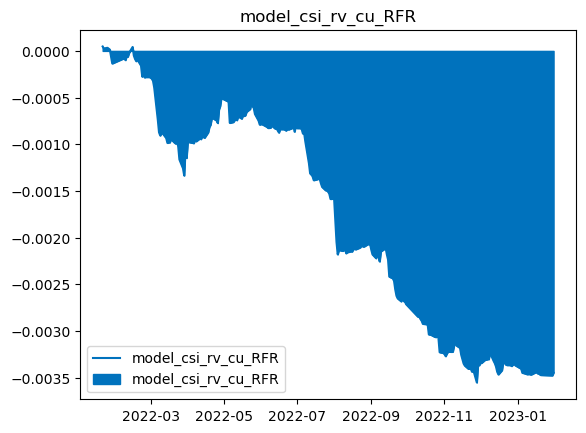

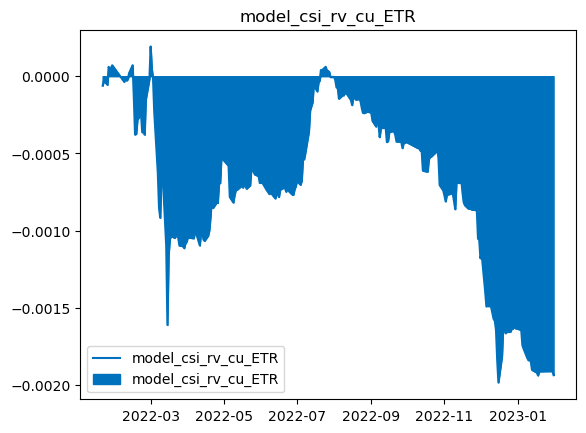

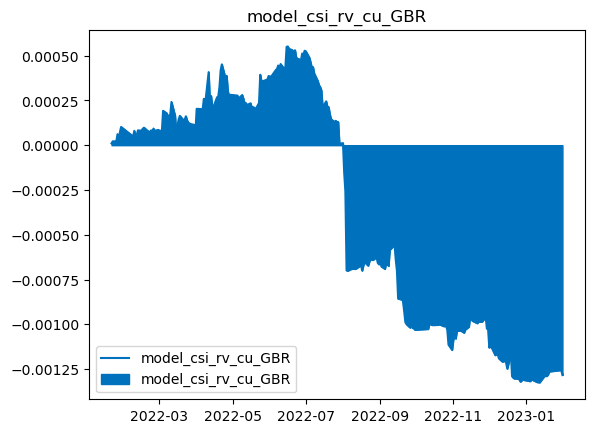

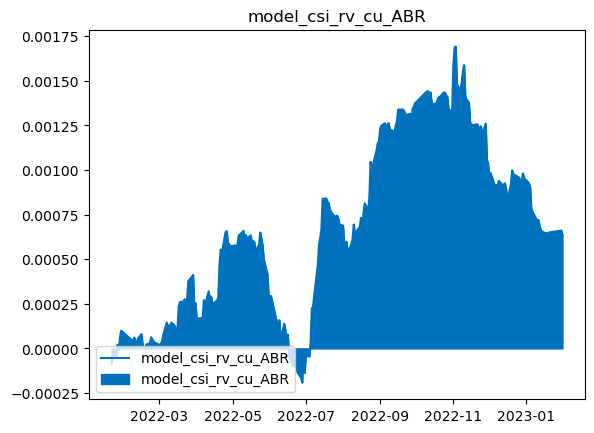

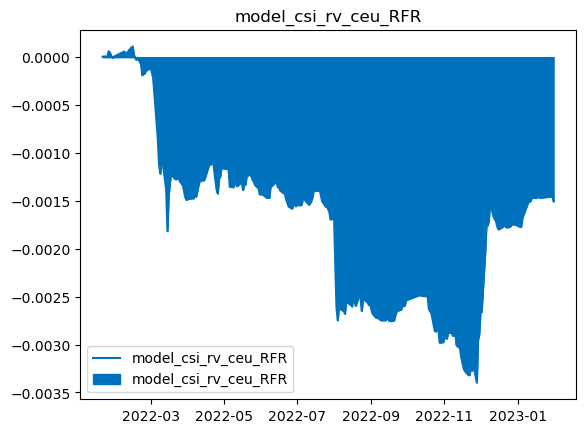

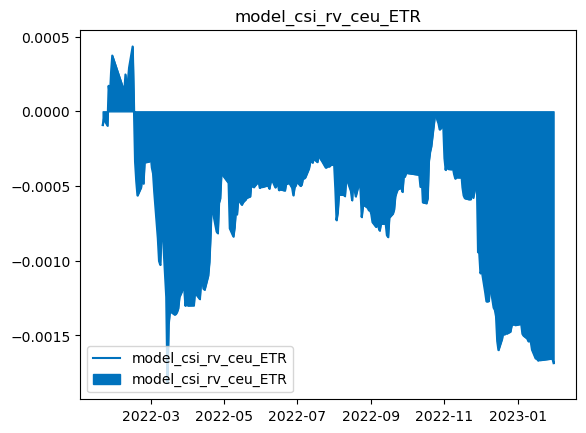

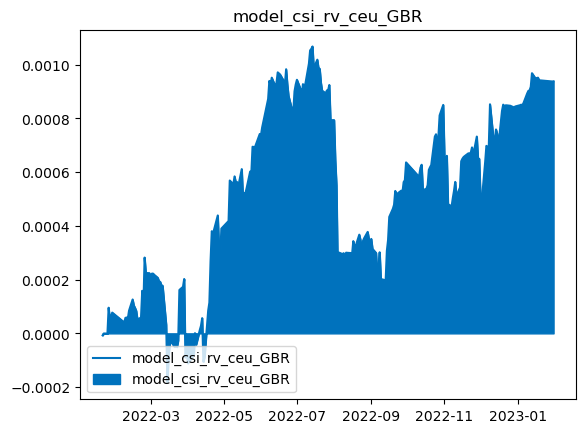

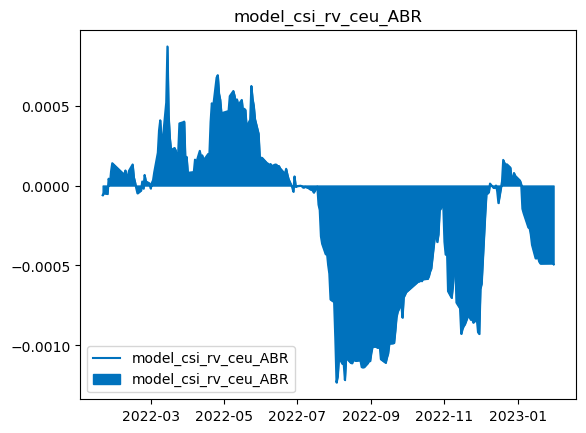

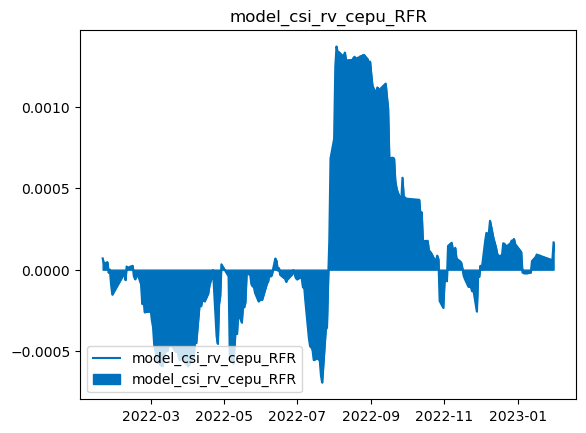

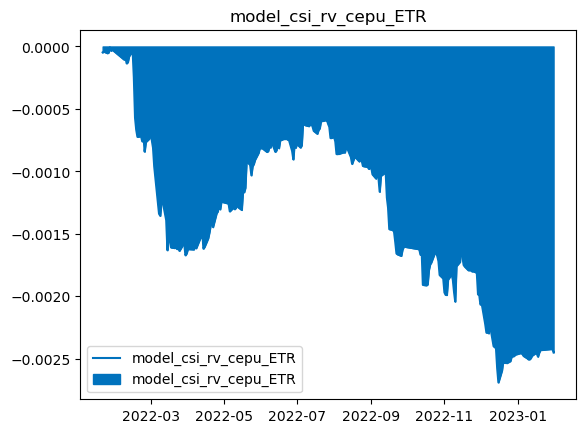

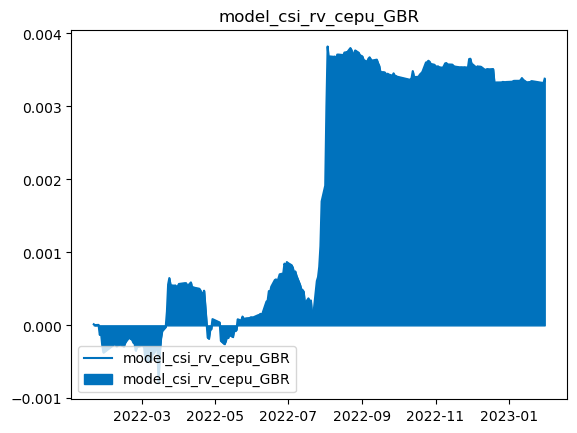

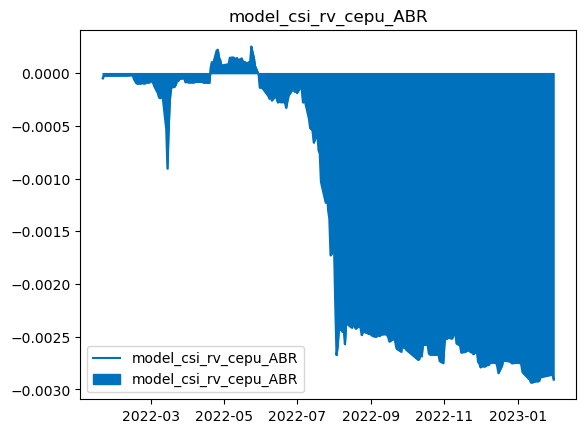

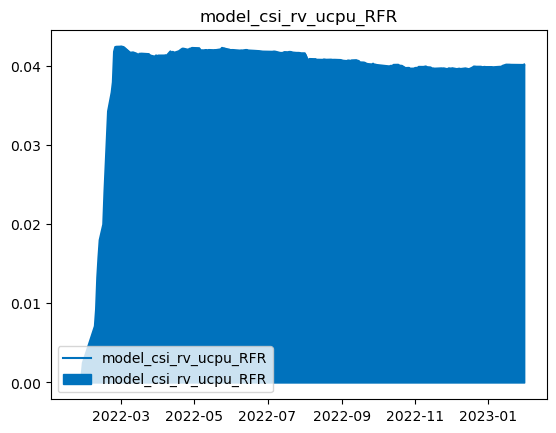

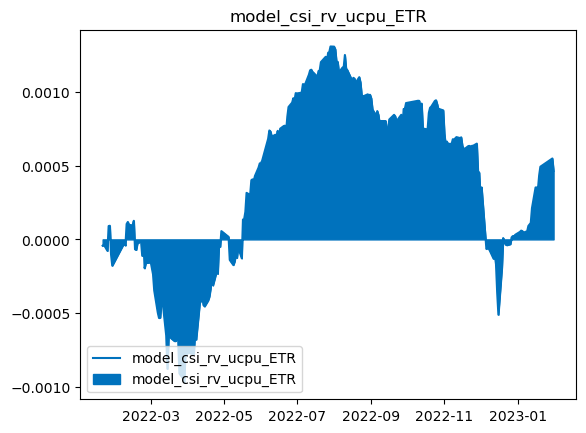

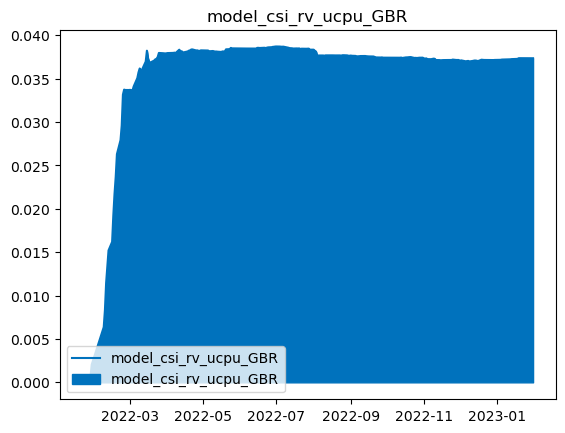

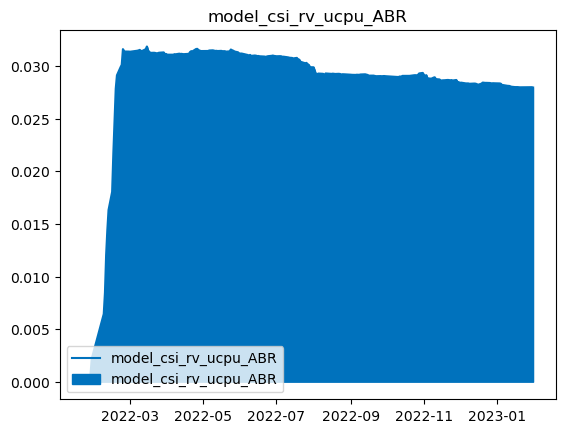

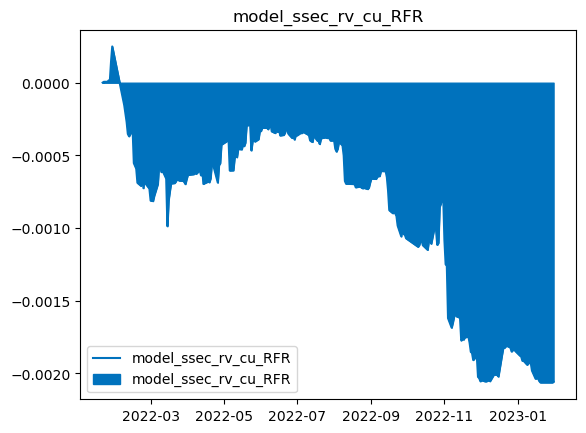

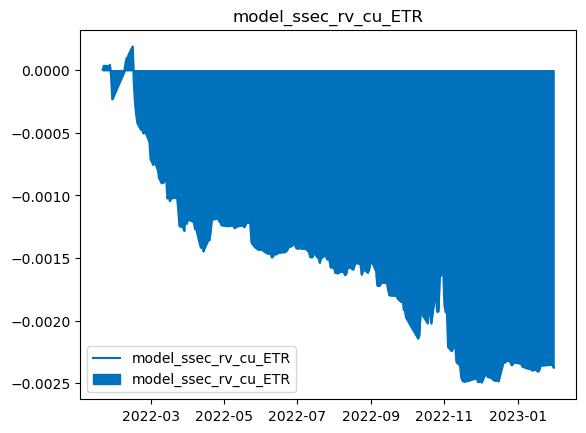

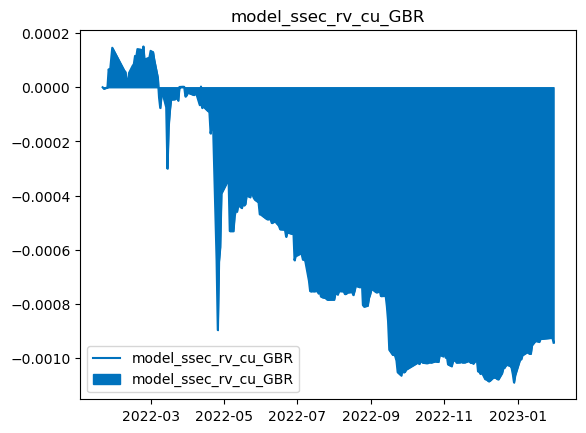

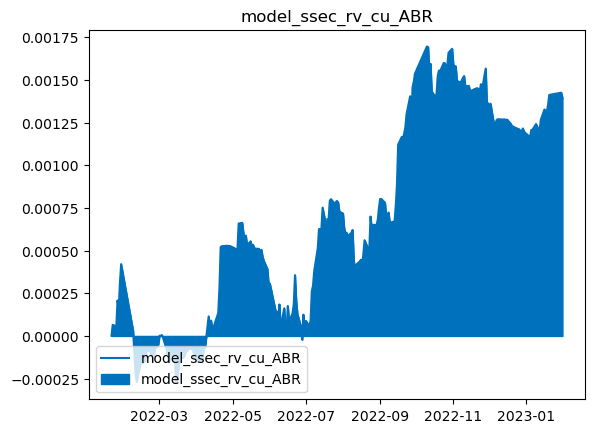

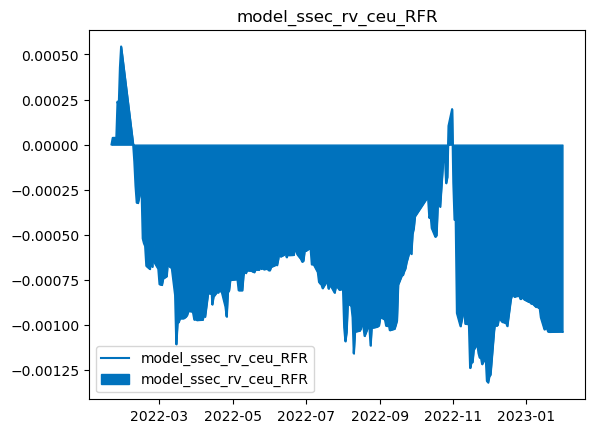

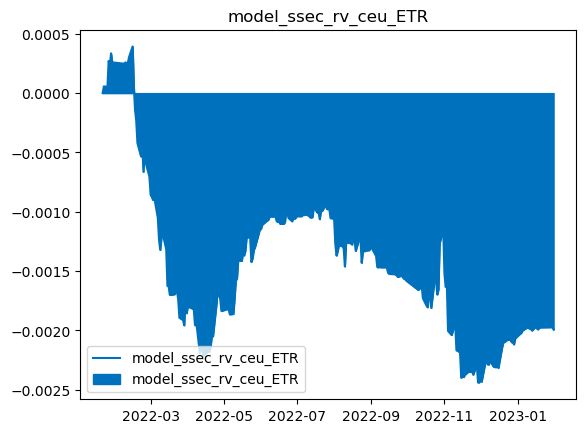

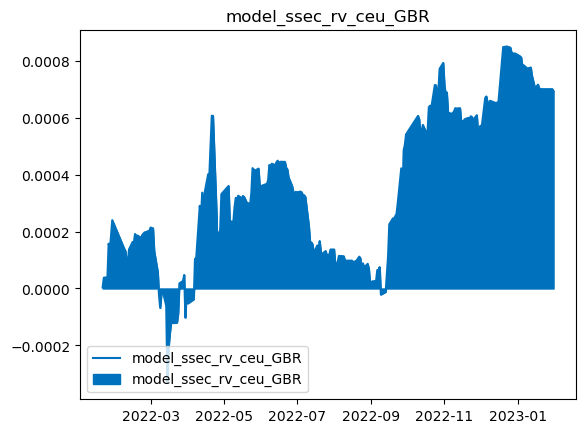

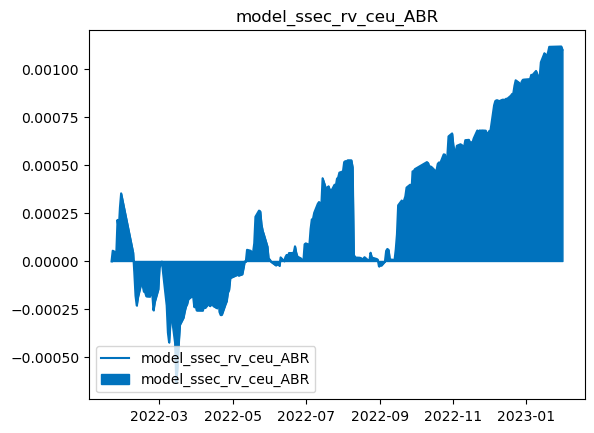

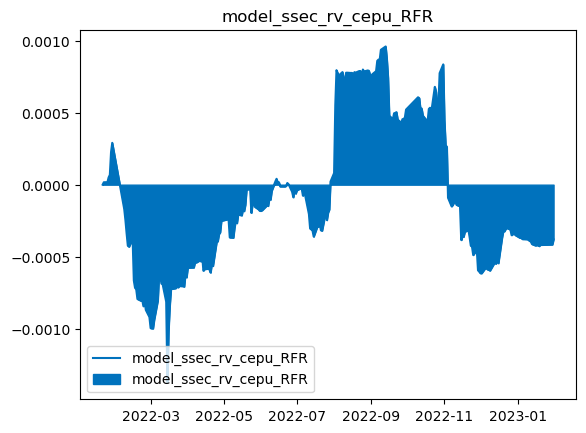

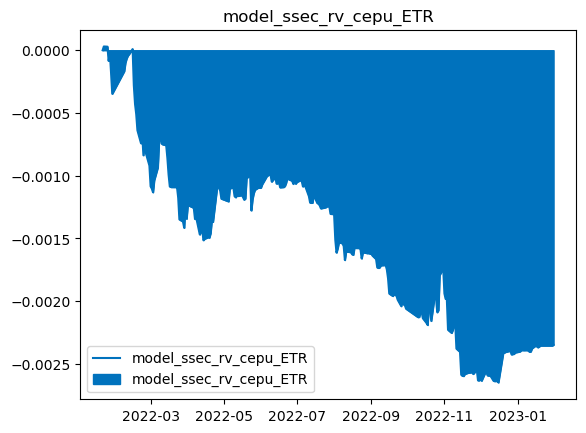

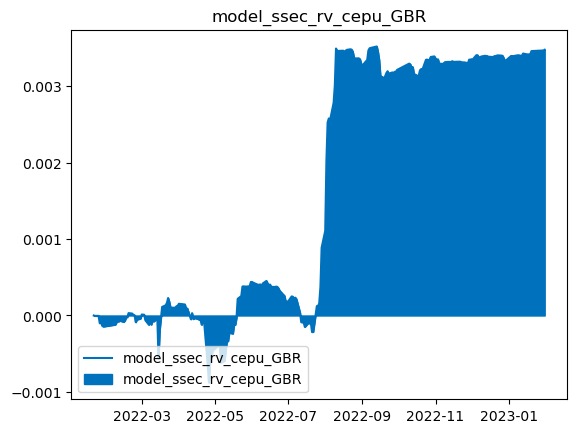

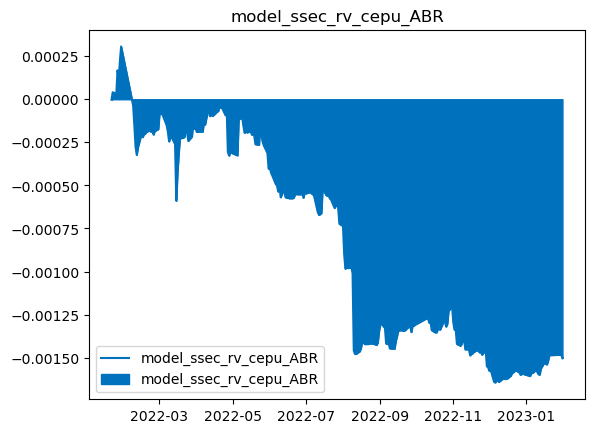

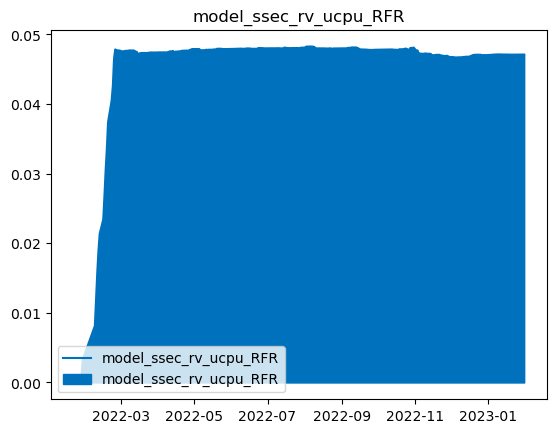

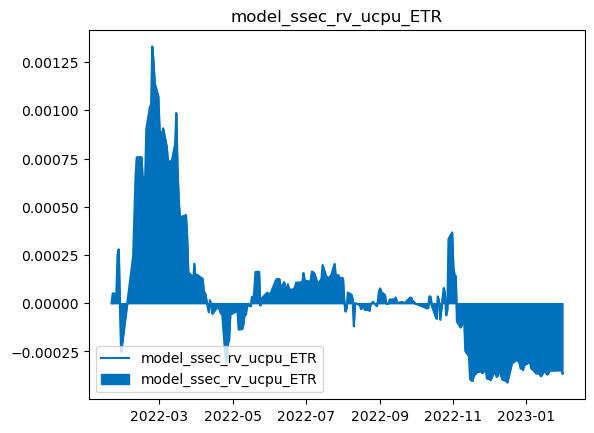

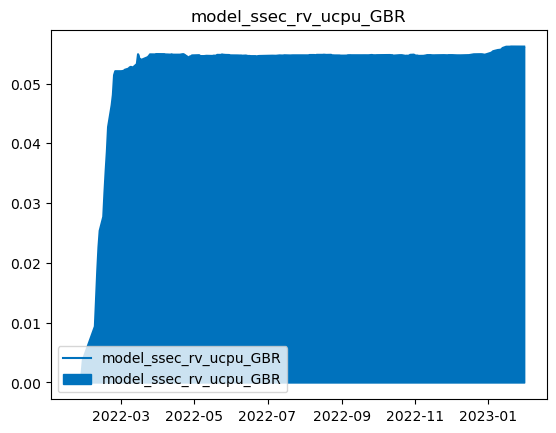

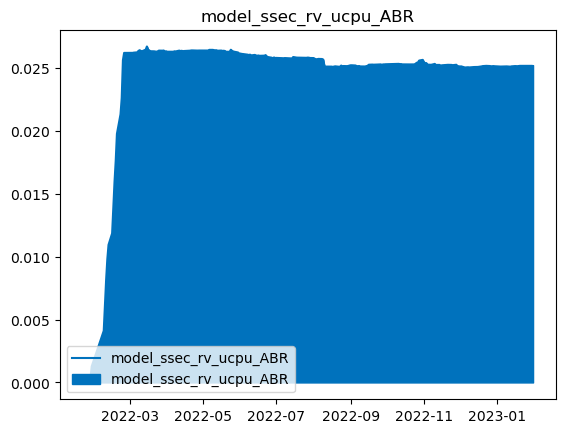

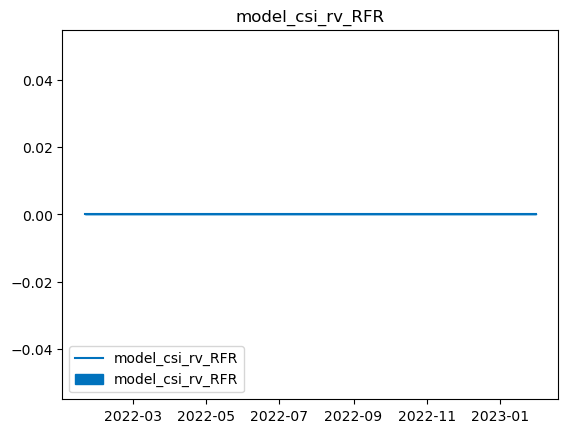

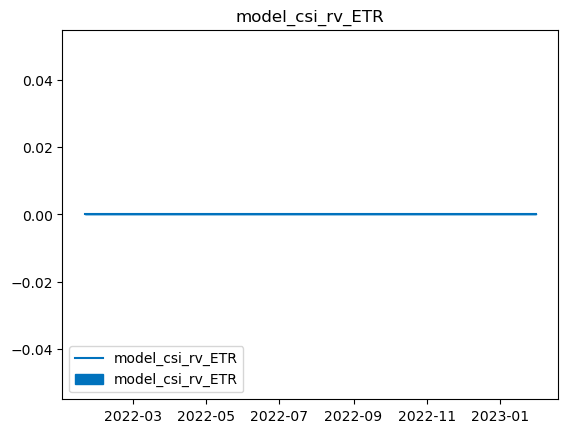

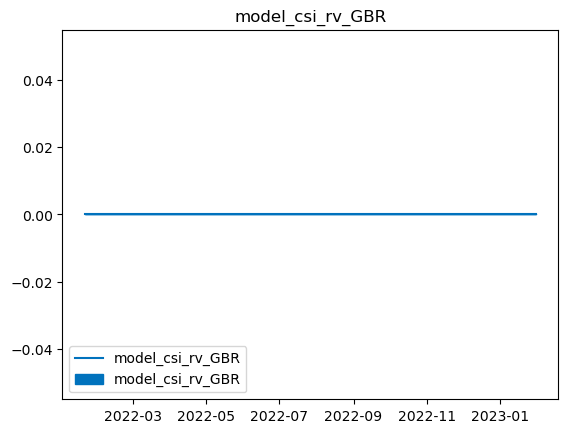

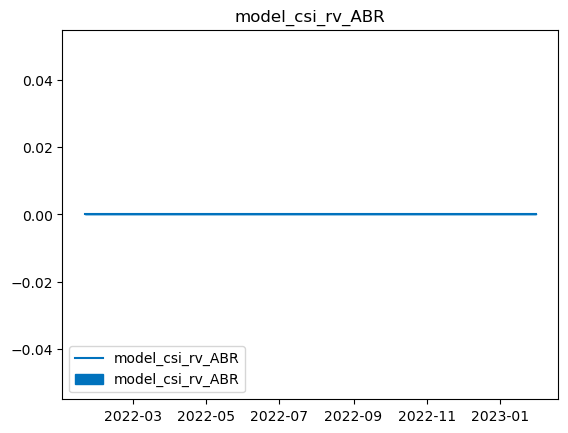

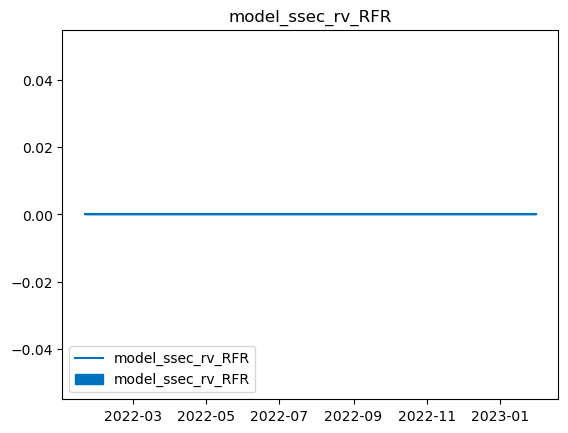

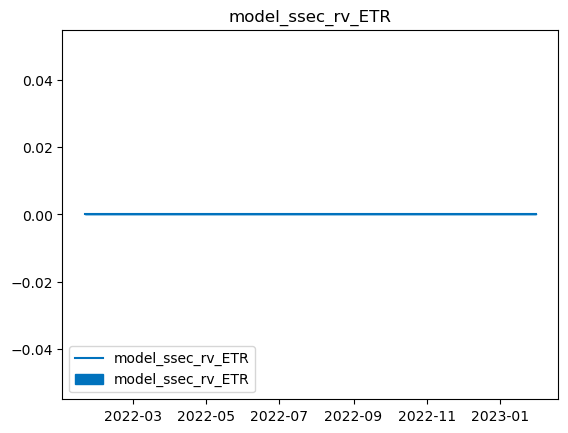

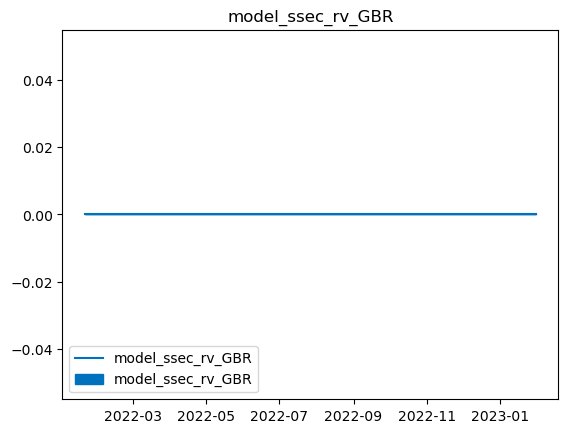

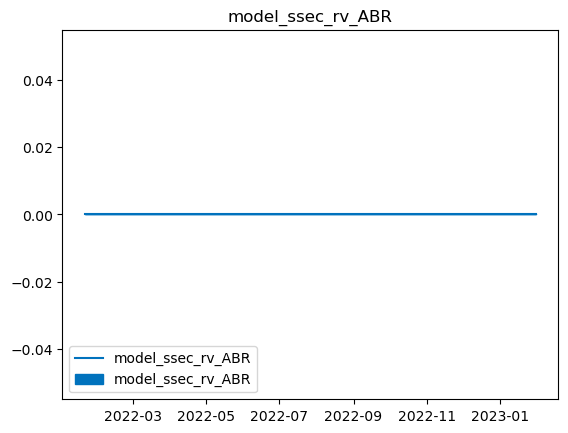

In [128]:
for m in modelparamsdf['model']:
    new_dict = CUM_SFE_metrix[m]["csfe"]
    # print(new_dict)
    for n in ["RFR","ETR","GBR","ABR"]:
        final_dict = new_dict[n]
        color_scheme = (0/255,114/255,189/255) 
# Plot each line in its respective subplot
        plt.plot(final_dict['date'], final_dict['CSFE'], color = color_scheme, label=str(m)+'_'+str(n))
        plt.fill_between(final_dict['date'], final_dict['CSFE'], color = color_scheme, label=str(m)+'_'+str(n))
        plt.title(str(m)+'_'+str(n))
        plt.legend(loc = 'lower left')
        plt.show()

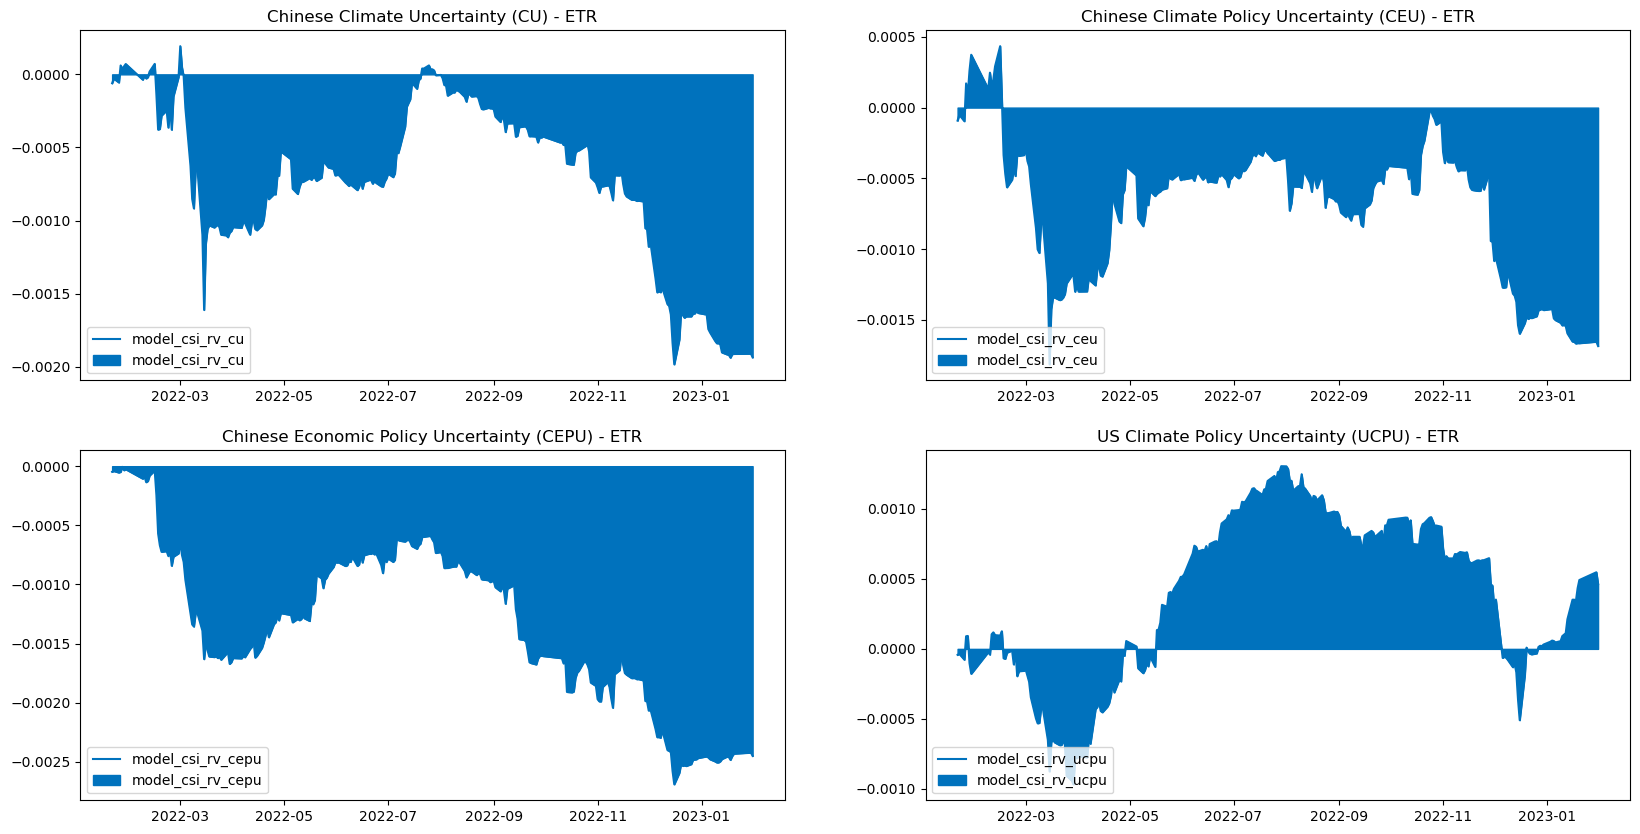

In [127]:
fig, axs = plt.subplots(2, 2, figsize=(20,10))

color_scheme = (0/255,114/255,189/255) 

# Plot each line in its respective subplot
axs[0, 0].plot(CUM_SFE_metrix['model_csi_rv_cu']["csfe"]["ETR"]['date'], CUM_SFE_metrix['model_csi_rv_cu']["csfe"]["ETR"]['CSFE'], color = color_scheme, label='model_csi_rv_cu')
axs[0, 0].fill_between(CUM_SFE_metrix['model_csi_rv_cu']["csfe"]["ETR"]['date'], CUM_SFE_metrix['model_csi_rv_cu']["csfe"]["ETR"]['CSFE'], color = color_scheme, label='model_csi_rv_cu')
axs[0, 0].set_title('Chinese Climate Uncertainty (CU) - ETR')
axs[0, 0].legend(loc = 'lower left')

axs[0, 1].plot(CUM_SFE_metrix['model_csi_rv_ceu']["csfe"]["ETR"]['date'], CUM_SFE_metrix['model_csi_rv_ceu']["csfe"]["ETR"]['CSFE'],  color = color_scheme, label='model_csi_rv_ceu')
axs[0, 1].fill_between(CUM_SFE_metrix['model_csi_rv_ceu']["csfe"]["ETR"]['date'], CUM_SFE_metrix['model_csi_rv_ceu']["csfe"]["ETR"]['CSFE'], color = color_scheme, label='model_csi_rv_ceu')
axs[0, 1].set_title('Chinese Climate Policy Uncertainty (CEU) - ETR')
axs[0, 1].legend(loc = 'lower left')

axs[1, 0].plot(CUM_SFE_metrix['model_csi_rv_cepu']["csfe"]["ETR"]['date'], CUM_SFE_metrix['model_csi_rv_cepu']["csfe"]["ETR"]['CSFE'], color = color_scheme, label='model_csi_rv_cepu')
axs[1, 0].fill_between(CUM_SFE_metrix['model_csi_rv_cepu']["csfe"]["ETR"]['date'], CUM_SFE_metrix['model_csi_rv_cepu']["csfe"]["ETR"]['CSFE'], color = color_scheme, label='model_csi_rv_cepu')
axs[1, 0].set_title('Chinese Economic Policy Uncertainty (CEPU) - ETR')
axs[1, 0].legend(loc = 'lower left')

axs[1, 1].plot(CUM_SFE_metrix['model_csi_rv_ucpu']["csfe"]["ETR"]['date'], CUM_SFE_metrix['model_csi_rv_ucpu']["csfe"]["ETR"]['CSFE'], color=color_scheme, label='model_csi_rv_ucpu')
axs[1, 1].fill_between(CUM_SFE_metrix['model_csi_rv_ucpu']["csfe"]["ETR"]['date'], CUM_SFE_metrix['model_csi_rv_ucpu']["csfe"]["ETR"]['CSFE'], color=color_scheme, label='model_csi_rv_ucpu')
axs[1, 1].set_title('US Climate Policy Uncertainty (UCPU) - ETR')
axs[1, 1].legend(loc = 'lower left')

# Adjust layout

# Show the plot
plt.show()